# 🌾 Predicción de precios de commodities agrícolas con modelos de series temporales

# Tabla de Contenidos

- [1. Introducción](#1-introducción)
- [2. Carga y visualización de las series](#2-carga-y-visualización-de-las-series)
- [3. Modelado y Evaluación](#3-modelado-y-evaluacion)
  - [3.0 Baseline naïve](#30--baseline-naïve)
  - [3.1 Modelos de Machine Learning Clásico](#31--modelos-de-machine-learning-clasico)
    - [3.1.1 Bagging Regressor](#311-bagging-regressor)
    - [3.1.2 AdaBoost Regressor](#312-adaboost-regressor)
    - [3.1.3 LightGMB](#313-lightgbm)
    - [3.1.4 Random Forest Regressor](#314-random-forest-regressor)
    - [3.1.5 Gradient Boosting Regressor](#315-gradient-boosting-regressor)
    - [3.1.6 Cuadro resumen de los Modelos de Machine Learning Clásico](#316-cuadro-resumen-de-los-modelos-de-machine-learning-clásicos)
  - [3.2 Modelos de Redes Neuronales](#32--modelos-de-redes-neuronales)
    - [3.2.1 NNAR simple](#321-nnar-simple)
    - [3.2.2 NNAR ajustado](#322-nnar-ajustado)
    - [3.2.3 LSTM simple](#323-lstm-simple)
    - [3.2.4 LSTM ajustado](#324-lstm-ajustado)
    - [3.2.5 MLP Regressor](#325-mlp-regressor)
    - [3.2.6 Cuadro resumen de los Modelos de Redes Neuronales](#326-cuadro-resumen-de-los-modelos-de-redes-neuronales)
  - [3.3 Modelos Estadísticos](#33--modelos-estadísticos)
    - [3.3.1 GLM Gaussiano](#331-glm-gaussiano)
    - [3.3.2 GLM Poisson](#332-glm-poisson)
    - [3.3.3 ARIMA](#333-arima)
    - [3.3.4 SARIMA](#334-sarima)
    - [3.3.5 Cuadro Resumen de Modelos Estadísticos](#335-cuadro-resumen-de-modelos-estadísticos)
- [4. AutoML](#4-️-automl)
  - [4.1 AutoTS](#41-autots)
      [4.2.1 Cuadro Resumen del desempeño de Autogluon](#421-cuadro-resumen-del-desempeño-de-autogluon)
- [5. Comparación Final de Modelos y Selección del Ganador](#5-comparación-final-de-modelos-y-selección-del-ganador)
- [6. Pronóstico Final con Modelo Seleccionado GLM Gaussiano](#6-pronóstico-con-el-modelo-seleccionado-glm-gaussiano)
- [7. Analisis de Estacionalidad STL](#7-análisis-de-estacionalidad-stl)
- [8. Evaluacion Ex-Post con Datos Reales Observados Oct 2024 - May 2025](#8-evaluación-ex-post-con-datos-reales-observados-oct-2024--may-2025)
- [9. Reflexion Final y Aprendizajes](#9-reflexión-final-y-apredizajes)



## 1. Introducción

Este análisis tiene como objetivo predecir precios de commodities agropecuarios (maíz, soja, carne) aplicando y comparando distintos modelos de series temporales: clásicos, redes neuronales, estadísticos, AutoML (AutoTS).


## 2. Carga y visualización de las series

- **Fuente:** [World Bank Commodity Price Data (The Pink Sheet)](https://www.worldbank.org/en/research/commodity-markets)
- **Cobertura:** Precios mensuales en dólares estadounidenses nominales, desde 1960 hasta el presente.
- **Moneda:** Las series están disponibles solo en **dólares nominales (USD)**.

**Variables utilizadas:**

| Producto | Unidad                         |
|----------|--------------------------------|
| Soja     | US Dollars per Metric Ton      |
| Maíz     | US Dollars per Metric Ton      |
| Carne    | US Dollars per Kilogram        |

Se cargan los precios históricos mensuales desde un archivo Excel, se visualizan las primeras filas y se chequea que los datos estén completos.  
No se realizó limpieza adicional ya que las columnas estaban en buen estado.

In [1]:
from src.data import load_all, load_commodity

# DF completo con las cuatro columnas
df_full = load_all()
df_full.head()

# Series individuales
df_maiz  = load_commodity("maiz")
df_soja  = load_commodity("soja")
df_carne = load_commodity("carne")

# Vista rápida
display(df_maiz.head())



maiz
fecha                
2010-01-01  167.31400
2010-02-01  161.80248
2010-03-01  159.04672
2010-04-01  157.07832
2010-05-01  163.37720

## 3. Modelado y Evaluación 

### 3.0 📈 Baseline naïve
Uso del último valor observado como pronóstico. Servirá de referencia mínima indispensable.


In [2]:
from src.data import load_all
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1.  Cargar datos y definir horizonte
data = load_all()
H = 12                                     

rows = []
for serie in ['carne', 'maiz', 'soja']:
    y_true = data[serie].iloc[-H:]                 
    y_pred = np.repeat(data[serie].iloc[-H-1], H)  
    rows.append({
        "Cultivo": serie.capitalize(),
        "Modelo":  "Naïve último valor",
        "MAE":  round(mean_absolute_error(y_true, y_pred), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
    })

df_naive = pd.DataFrame(rows)
display(df_naive)                         
print(df_naive.to_markdown(index=False))


Cultivo              Modelo     MAE    RMSE
0   Carne  Naïve último valor    0.73    0.90
1    Maiz  Naïve último valor   29.83   32.47
2    Soja  Naïve último valor  127.96  137.84

| Cultivo   | Modelo             |    MAE |   RMSE |
|:----------|:-------------------|-------:|-------:|
| Carne     | Naïve último valor |   0.73 |   0.9  |
| Maiz      | Naïve último valor |  29.83 |  32.47 |
| Soja      | Naïve último valor | 127.96 | 137.84 |


### 3.1 📈 Modelos de Machine Learning Clásico

En esta sección se aplican modelos de regresión clásicos y de ensamblado que, si bien no están diseñados específicamente para series temporales, se adaptan mediante el uso de variables retrasadas (lags).  
Estos modelos fueron entrenados y evaluados individualmente para cada una de las tres series: carne, maíz y soja.

### Modelos utilizados:

  
- **Bagging Regressor:** técnica de ensamblado que reduce la varianza al promediar múltiples estimadores.  
- **AdaBoost Regressor:** algoritmo de boosting que corrige los errores secuencialmente a partir de modelos débiles.  
- **LightGBM Regressor:** boosting basado en histogramas, optimizado para velocidad y escalabilidad.
- **Random Forest Regressor:** conjunto de árboles entrenados con bagging (muestreo con reemplazo).
- **Gradient Boosting Regressor:** mejora iterativa de árboles de decisión minimizando el error residual. 


Cada uno de estos modelos fue evaluado con las métricas MAE, RMSE y MAPE, para medir su capacidad predictiva sobre los últimos 12 meses de cada serie.


#### 3.1.1 Bagging Regressor

Resultados para Carne:
MAE: 0.25457659411971506
RMSE: 0.31754490951466313
MAPE: 4.48%


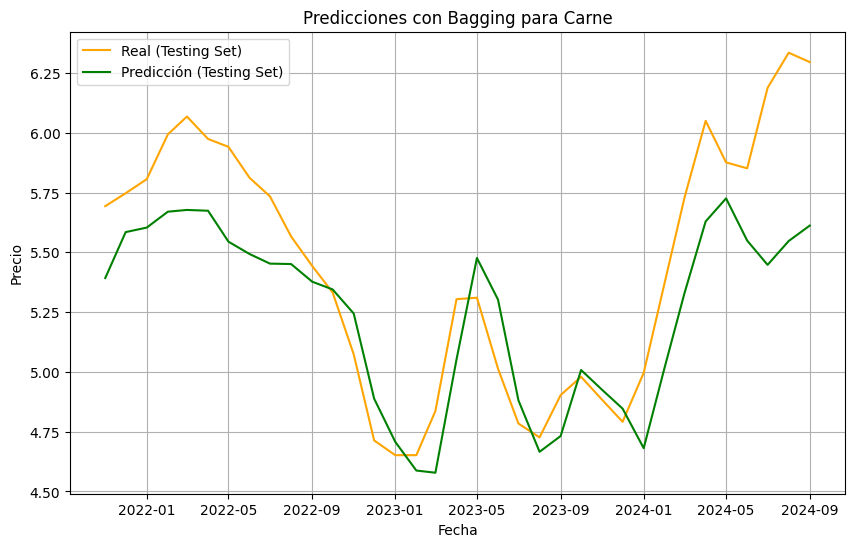

Resultados para Maíz:
MAE: 16.33288804333568
RMSE: 21.149685498530843
MAPE: 6.47%


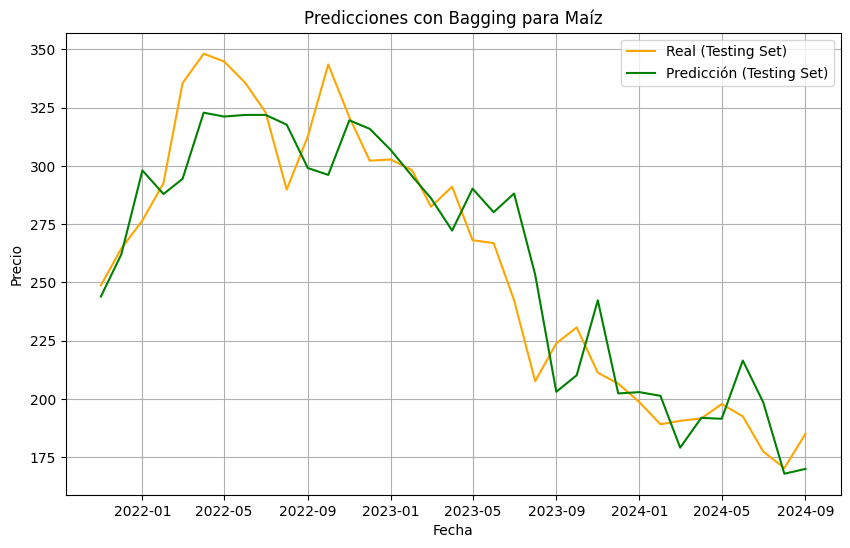

Resultados para Soja:
MAE: 34.68140373317235
RMSE: 42.971612336038596
MAPE: 5.79%


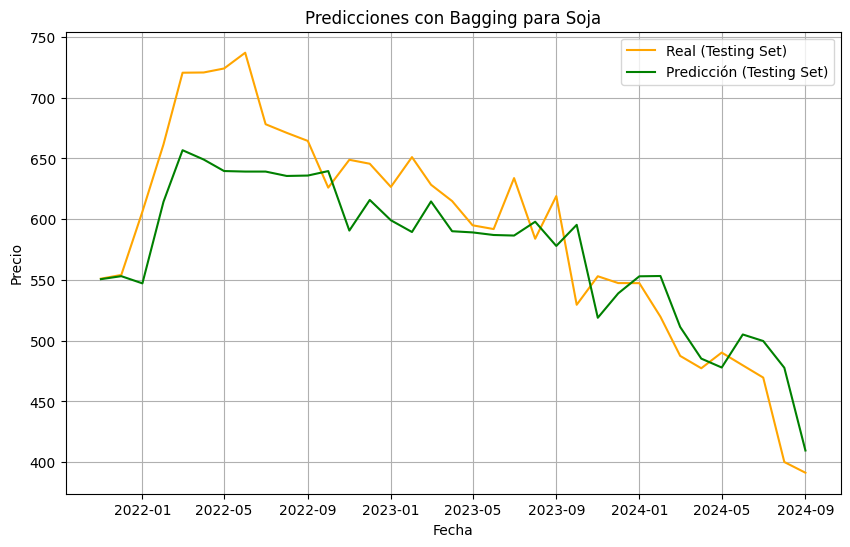

In [3]:
from src.data import load_all
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

data = load_all()

# Crear características de series temporales (usando retrasos)
def create_features(data, n_lags=3):
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    df['target'] = data
    return df.dropna()

# Crear características para cada commodity
df_carne = create_features(data['carne'])
df_maiz = create_features(data['maiz'])
df_soja = create_features(data['soja'])

# Función para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función para entrenar y evaluar Bagging
def train_and_evaluate_bagging(df_features, nombre_serie):
    # Dividir en Train y Test
    X = df_features.drop(columns=['target'])
    y = df_features['target']
    train_size = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Ajustar el modelo Bagging
    model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)

    # Evaluar el rendimiento
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Resultados para {nombre_serie}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Real (Testing Set)', color='orange')
    plt.plot(y_test.index, y_pred, label='Predicción (Testing Set)', color='green')
    plt.legend()
    plt.title(f'Predicciones con Bagging para {nombre_serie}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar Bagging para cada commodity
train_and_evaluate_bagging(df_carne, 'Carne')
train_and_evaluate_bagging(df_maiz, 'Maíz')
train_and_evaluate_bagging(df_soja, 'Soja')

#### 3.1.2 AdaBoost Regressor

Resultados para Carne:
MAE: 0.24661891032986064
RMSE: 0.3112028938132387
MAPE: 4.41%


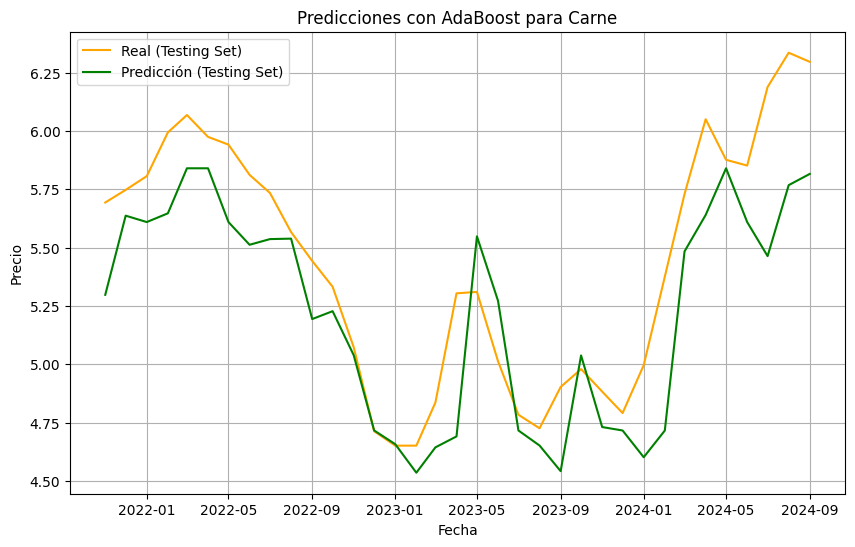

Resultados para Maíz:
MAE: 15.275381826857926
RMSE: 20.583979189806705
MAPE: 6.15%


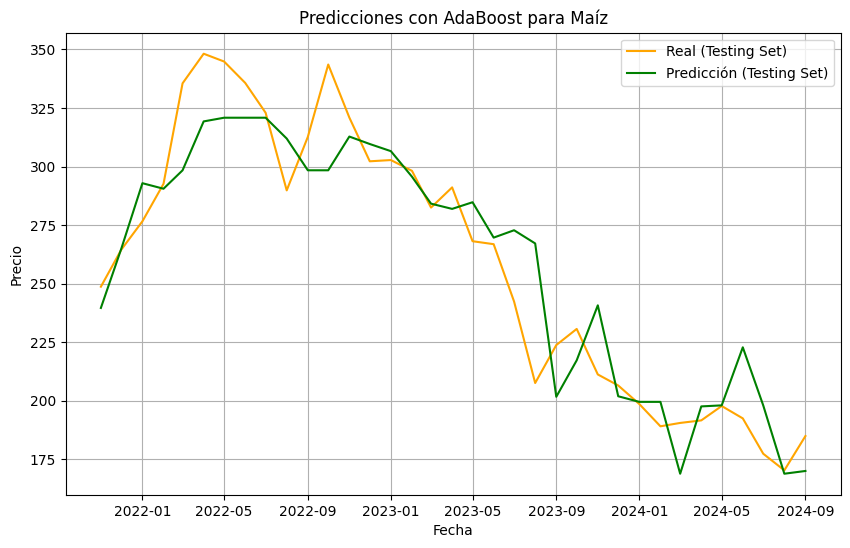

Resultados para Soja:
MAE: 38.1434149953363
RMSE: 48.6574693518935
MAPE: 6.33%


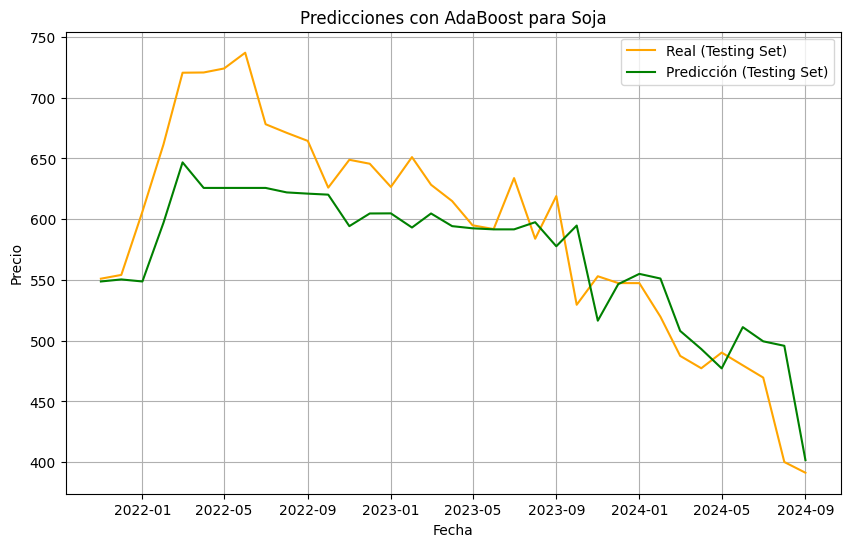

In [4]:
from src.data import load_all
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Cargar los datos
data = load_all()

# Crear características de series temporales (usando retrasos)
def create_features(data, n_lags=3):
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    df['target'] = data
    return df.dropna()

# Crear características para cada commodity
df_carne = create_features(data['carne'])
df_maiz = create_features(data['maiz'])
df_soja = create_features(data['soja'])

# Función para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función para entrenar y evaluar AdaBoost
def train_and_evaluate_adaboost(df_features, nombre_serie):
    # Dividir en Train y Test
    X = df_features.drop(columns=['target'])
    y = df_features['target']
    train_size = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Ajustar el modelo AdaBoost
    model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5), n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)

    # Evaluar el rendimiento
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Resultados para {nombre_serie}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Real (Testing Set)', color='orange')
    plt.plot(y_test.index, y_pred, label='Predicción (Testing Set)', color='green')
    plt.legend()
    plt.title(f'Predicciones con AdaBoost para {nombre_serie}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar AdaBoost para cada commodity
train_and_evaluate_adaboost(df_carne, 'Carne')
train_and_evaluate_adaboost(df_maiz, 'Maíz')
train_and_evaluate_adaboost(df_soja, 'Soja')

##### 3.1.3 LightGBM

In [5]:
from src.data import load_all
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Cargar los datos
data = load_all()

# Crear características de series temporales (usando retrasos)
def create_features(data, n_lags=3):
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    df['target'] = data
    return df.dropna()

# Crear características para cada commodity
df_carne = create_features(data['carne'])
df_maiz = create_features(data['maiz'])
df_soja = create_features(data['soja'])

# Función para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función para entrenar y evaluar LightGBM
def train_and_evaluate_lightgbm(df_features, nombre_serie):
    # Dividir en Train y Test
    X = df_features.drop(columns=['target'])
    y = df_features['target']
    train_size = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Ajustar el modelo LightGBM
    model = LGBMRegressor(objective='regression', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predicciones
    y_pred = model.predict(X_test)

    # Evaluar el rendimiento
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Resultados para {nombre_serie}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Real (Testing Set)', color='orange')
    plt.plot(y_test.index, y_pred, label='Predicción (Testing Set)', color='green')
    plt.legend()
    plt.title(f'Predicciones con LightGBM para {nombre_serie}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar LightGBM para cada commodity
train_and_evaluate_lightgbm(df_carne, 'Carne')
train_and_evaluate_lightgbm(df_maiz, 'Maíz')
train_and_evaluate_lightgbm(df_soja, 'Soja')

AttributeError: `np.unicode_` was removed in the NumPy 2.0 release. Use `np.str_` instead.

#### 3.1.4 Random Forest Regressor

Resultados para Carne:
MAE: 0.3256702691122873
RMSE: 0.20858963161852198
MAPE: 5.41%


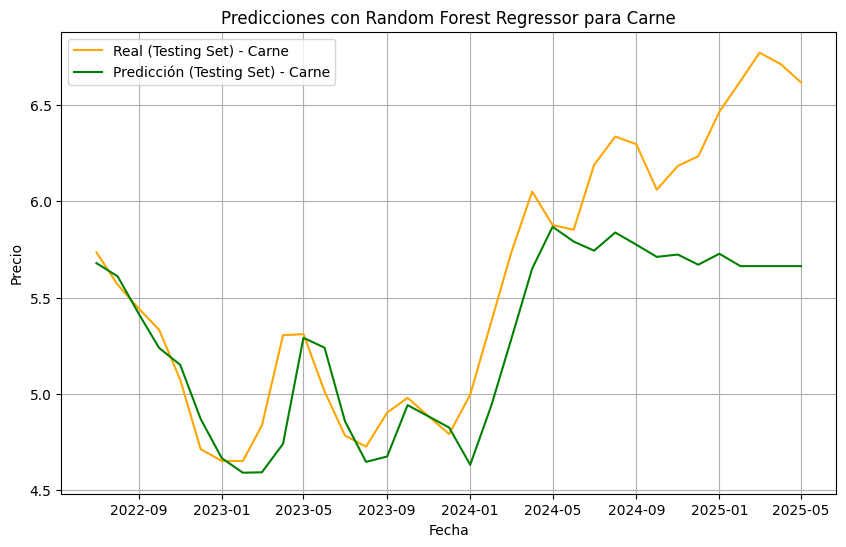

Resultados para Maíz:
MAE: 12.471124573229929
RMSE: 290.67093026371265
MAPE: 5.33%


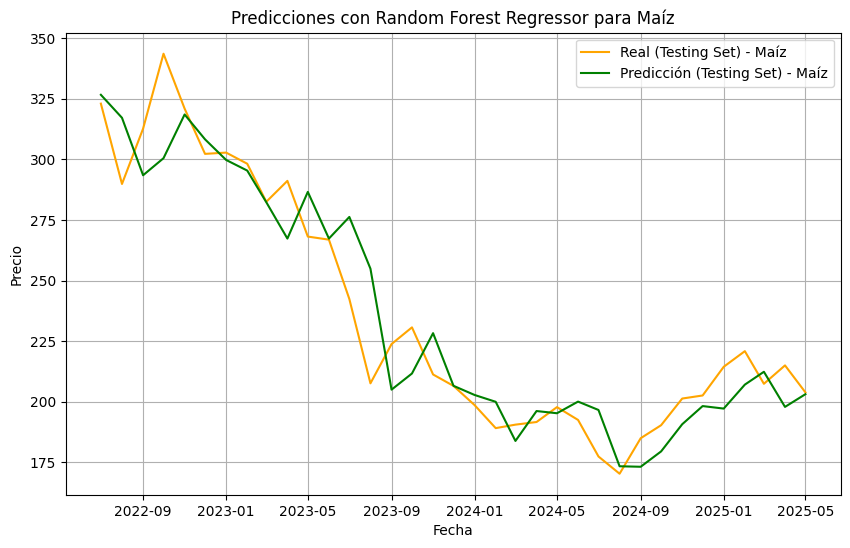

Resultados para Soja:
MAE: 27.468151003600614
RMSE: 1287.090180209849
MAPE: 5.27%


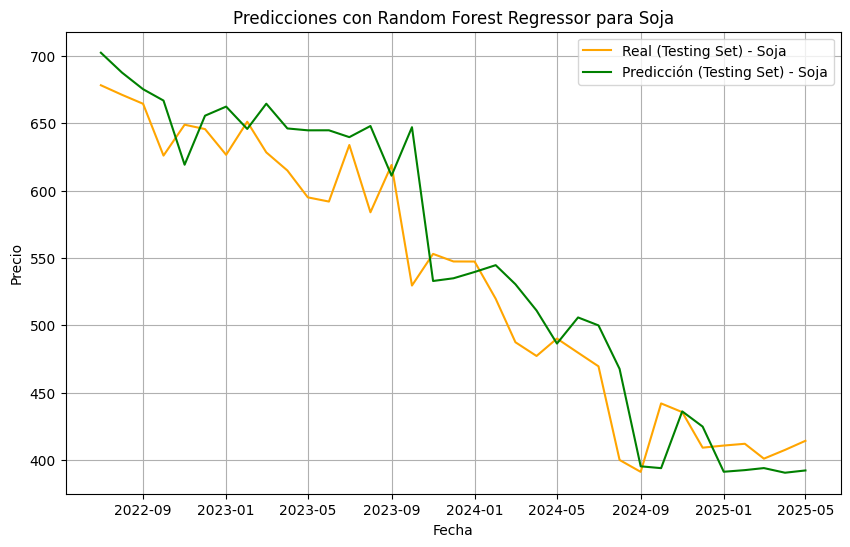

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Cargar los datos
data = load_all()

# Función para crear características y etiquetas
def create_lags(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Definir el número de retrasos
n_lags = 12

# Función para entrenar y evaluar el modelo 
def train_and_evaluate_rf(serie, nombre):
    # Crear características y etiquetas
    X, y = create_lags(serie.values, n_lags)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Aplanar las características para DRF
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

    # Ajustar el modelo DRF
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = model.predict(X_test)

    # Evaluar el rendimiento del modelo
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f'Resultados para {nombre}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {mse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados con fechas reales
    plt.figure(figsize=(10, 6))
    plt.plot(serie.index[-len(y_test):], y_test, label=f'Real (Testing Set) - {nombre}', color='orange')
    plt.plot(serie.index[-len(y_test):], y_pred, label=f'Predicción (Testing Set) - {nombre}', color='green')
    plt.legend()
    plt.title(f'Predicciones con Random Forest Regressor para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar el modelo para Carne, Maíz y Soja
train_and_evaluate_rf(data['carne'], 'Carne')
train_and_evaluate_rf(data['maiz'], 'Maíz')
train_and_evaluate_rf(data['soja'], 'Soja')

#### 3.1.5 Gradient Boosting Regressor

Resultados para Carne:
MAE: 0.3449509687821155
RMSE: 0.2110631485281975
MAPE: 5.77%


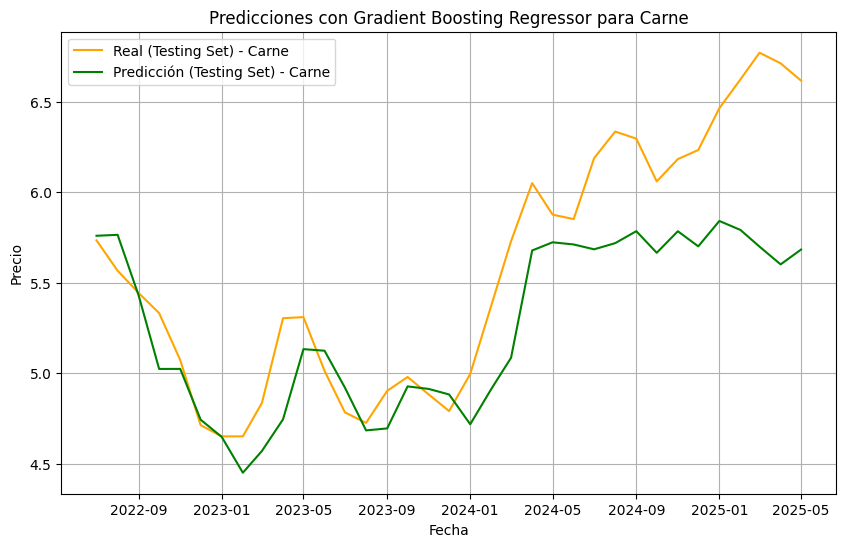

Resultados para Maíz:
MAE: 13.81953820796532
RMSE: 321.3460610069721
MAPE: 5.91%


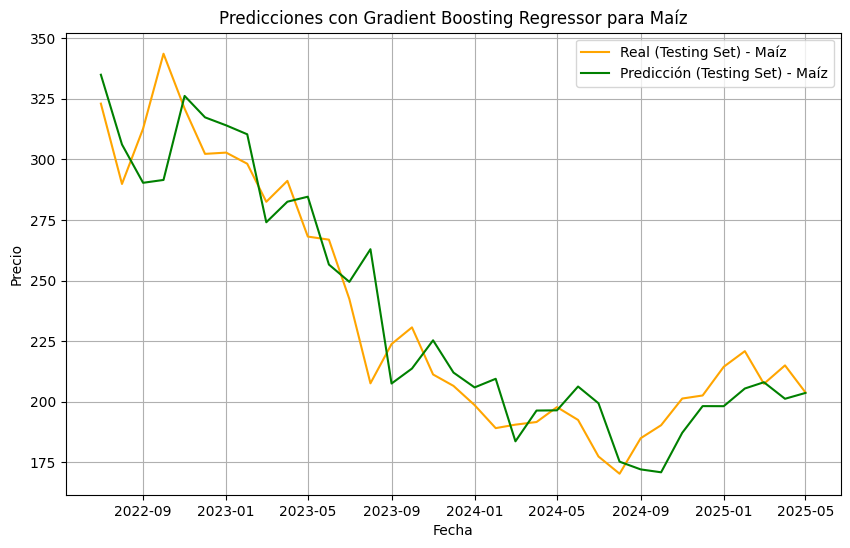

Resultados para Soja:
MAE: 26.69362936911941
RMSE: 1257.2051968493845
MAPE: 5.11%


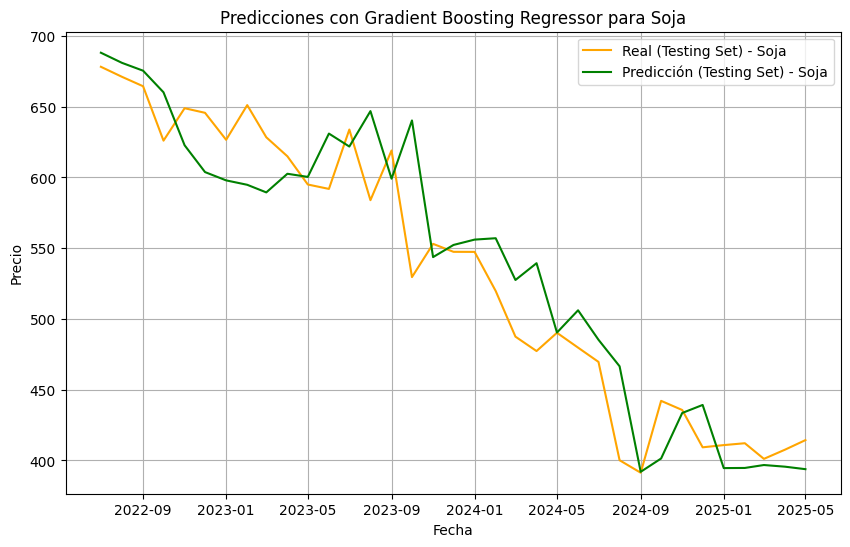

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Cargar los datos
data = load_all()

# Función para crear características y etiquetas
def create_lags(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Definir el número de retrasos
n_lags = 12

# Función para entrenar y evaluar el modelo GBM
def train_and_evaluate_gbm(serie, nombre):
    # Crear características y etiquetas
    X, y = create_lags(serie.values, n_lags)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Aplanar las características para GBM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

    # Ajustar el modelo GBM
    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = model.predict(X_test)

    # Evaluar el rendimiento del modelo
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f'Resultados para {nombre}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {mse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados con fechas reales
    plt.figure(figsize=(10, 6))
    plt.plot(serie.index[-len(y_test):], y_test, label=f'Real (Testing Set) - {nombre}', color='orange')
    plt.plot(serie.index[-len(y_test):], y_pred, label=f'Predicción (Testing Set) - {nombre}', color='green')
    plt.legend()
    plt.title(f'Predicciones con Gradient Boosting Regressor para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar el modelo para Carne, Maíz y Soja
train_and_evaluate_gbm(data['carne'], 'Carne')
train_and_evaluate_gbm(data['maiz'], 'Maíz')
train_and_evaluate_gbm(data['soja'], 'Soja')

### 3.1.6 Cuadro Resumen de los Modelos de Machine Learning Clásicos

A continuación, se presentan las métricas de rendimiento (MAE, MSE y MAPE) obtenidas por cada modelo clásico de machine learning aplicado a los tres commodities analizados: maíz, soja y carne.

 **Resultados para Carne:**            

| Modelo                      | MAE     | RMSE    | MAPE  |
|-----------------------------|---------|---------|-------|
| Bagging Regressor           | 0.2546  | 0.3175  | 4.48% |
| AdaBoost Regressor          | 0.2466  | 0.3112  | 4.41% |
| LightGBM Regressor          | 0.4233  | 0.4900  | 7.66% |
| Random Forest Regressor     | 0.3673  | 0.2119  | 6.39% |
| Gradient Boosting Regressor | 0.3693  | 0.2260  | 6.42% |

 `Ganador: AdaBoost Regressor`                       

---

**Resultados para Maíz:**    

| Modelo                      | MAE     | RMSE     | MAPE  |
|-----------------------------|---------|----------|-------|
| Bagging Regressor           | 16.3329 | 21.1497  | 6.47% |
| AdaBoost Regressor          | 15.2754 | 20.5840  | 6.15% |
| LightGBM Regressor          | 16.7515 | 21.7858  | 6.33% |
| Random Forest Regressor     | 15.6225 | 401.9224 | 5.97% |
| Gradient Boosting Regressor | 13.9923 | 342.9470 | 5.52% |

`Ganador: Gradient Boosting Regressor`

---

**Resultados para Soja:**    

| Modelo                      | MAE     | RMSE     | MAPE  |
|-----------------------------|---------|----------|-------|
| Bagging Regressor           | 34.6814 | 42.9716  | 5.79% |
| AdaBoost Regressor          | 38.1434 | 48.6575  | 6.33% |
| LightGBM Regressor          | 42.2218 | 56.6981  | 6.81% |
| Random Forest Regressor     | 37.6114 | 2105.5330| 6.25% |
| Gradient Boosting Regressor | 50.7176 | 3755.0907| 8.23% |

` Ganador: Bagging Regressor`




### 3.2 📈 Modelos de Redes Neuronales

Los siguientes modelos están diseñados para capturar patrones no lineales y secuenciales en las series temporales.

### Modelos utilizados:
-  **NNAR (Neural Network AutoRegressive):** red neuronal simple (perceptrón) entrenada sobre ventanas de datos pasados, útil para patrones no lineales con estructura fija.
-  **LSTM (Long Short-Term Memory):** red neuronal recurrente que mantiene memoria de estados pasados, ideal para series con dependencia temporal prolongada.
- **MLP Regressor (Multilayer Perceptron):** red neuronal de tipo feedforward con múltiples capas ocultas, útil para capturar relaciones complejas entre variables, aplicada en este caso a regresión de series temporales.

####  3.2.1 NNAR Simple 

Este modelo NNAR utiliza solo 3 lags como entrada y una red neuronal básica con 10 neuronas ocultas. Es útil como punto de partida para evaluar patrones simples en las series.


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Resultados para Carne:
MAE: 0.2546420571336262
RMSE: 0.3157257878169165
MAPE: 12.78%


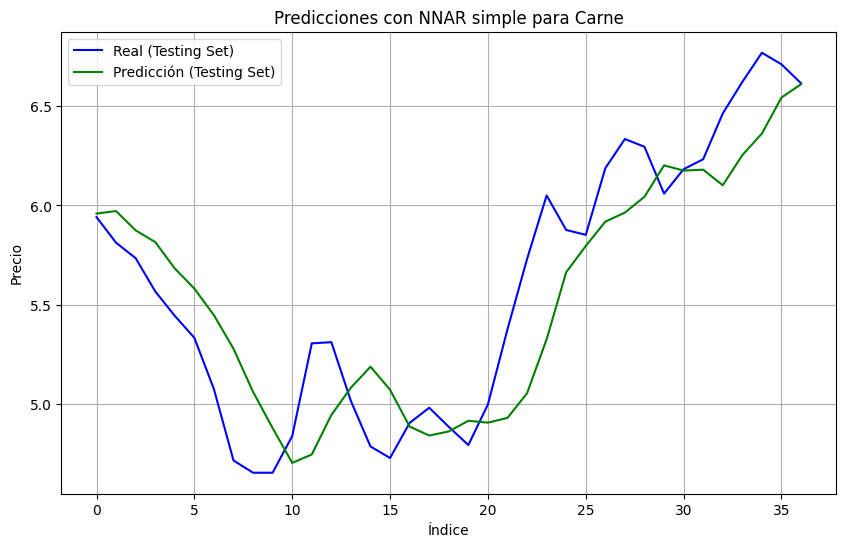

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Resultados para Maíz:
MAE: 14.86202149816233
RMSE: 18.71916897209852
MAPE: 26.32%


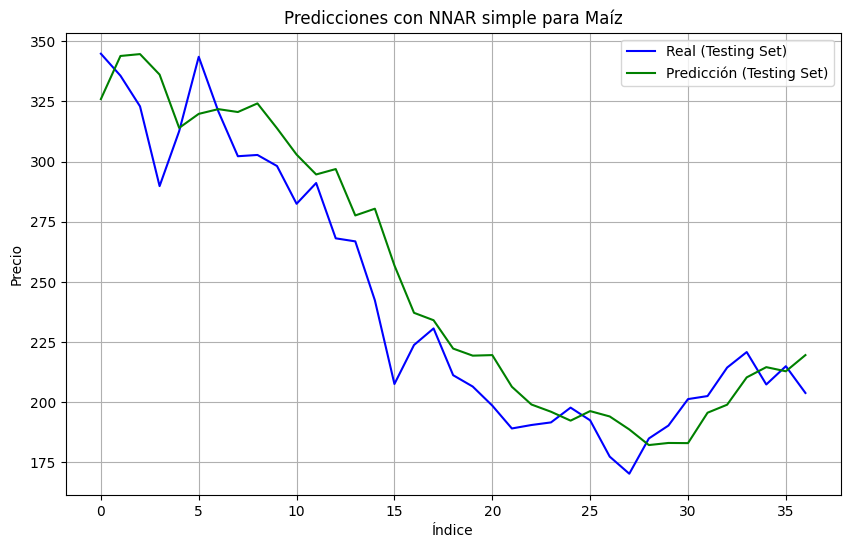

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002B83EFF9A80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Resultados para Soja:
MAE: 25.99910259652872
RMSE: 33.172562580483145
MAPE: 23.38%


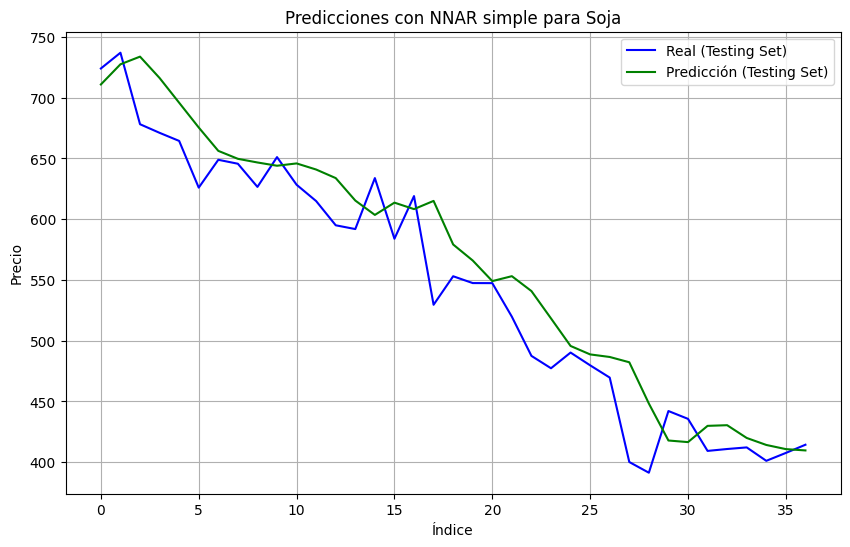

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import numpy as np

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Cargar los datos
data = load_all()

# Crear características de series temporales (usando retrasos)
def create_features(data, n_lags=3):
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    df['target'] = data
    return df.dropna()

# Crear características para cada commodity
df_carne = create_features(data['carne'])
df_maiz = create_features(data['maiz'])
df_soja = create_features(data['soja'])

# Función para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función para entrenar y evaluar NNAR
def train_and_evaluate_nnar(df_features, nombre_serie):
    # Dividir en Train y Test
    X = df_features.drop(columns=['target']).values
    y = df_features['target'].values
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Ajustar el modelo NNAR
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, verbose=0)

    # Predicciones
    y_pred = model.predict(X_test)

    # Evaluar el rendimiento
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Resultados para {nombre_serie}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, label='Real (Testing Set)', color='blue')
    plt.plot(range(len(y_test)), y_pred, label='Predicción (Testing Set)', color='green')
    plt.legend()
    plt.title(f'Predicciones con NNAR simple para {nombre_serie}')
    plt.xlabel('Índice')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar NNAR para cada commodity
train_and_evaluate_nnar(df_carne, 'Carne')
train_and_evaluate_nnar(df_maiz, 'Maíz')
train_and_evaluate_nnar(df_soja, 'Soja')

#### 3.2.2 NNAR Ajustado 

Este modelo ajustado de NNAR incorpora 12 lags como entradas y una arquitectura más compleja, con 50 neuronas ocultas y una tasa de aprendizaje explícita. Está diseñado para capturar dependencias temporales más largas y patrones no lineales más complejos en las series de precios.


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Resultados para Carne:
MAE: 0.20601865037625786
RMSE: 0.24735129708367706
MAPE: 3.86%


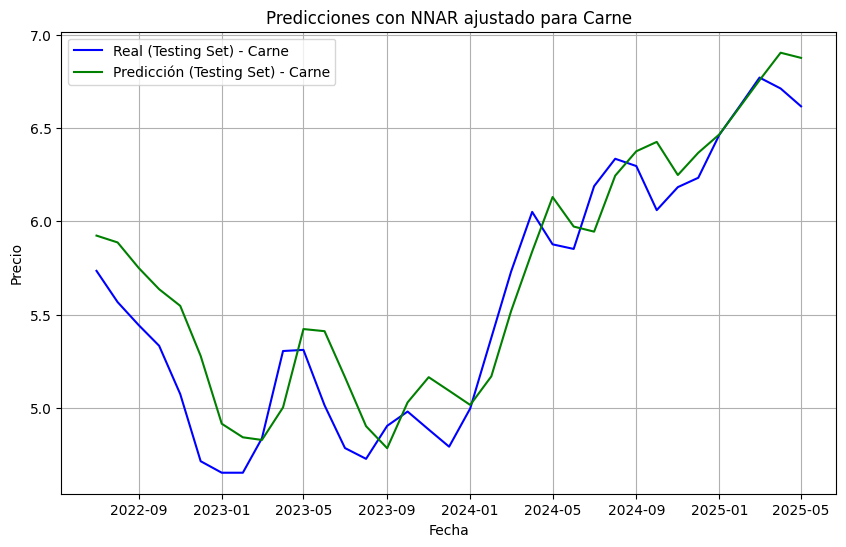

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Resultados para Maíz:
MAE: 13.971433335193485
RMSE: 17.03977037557338
MAPE: 5.90%


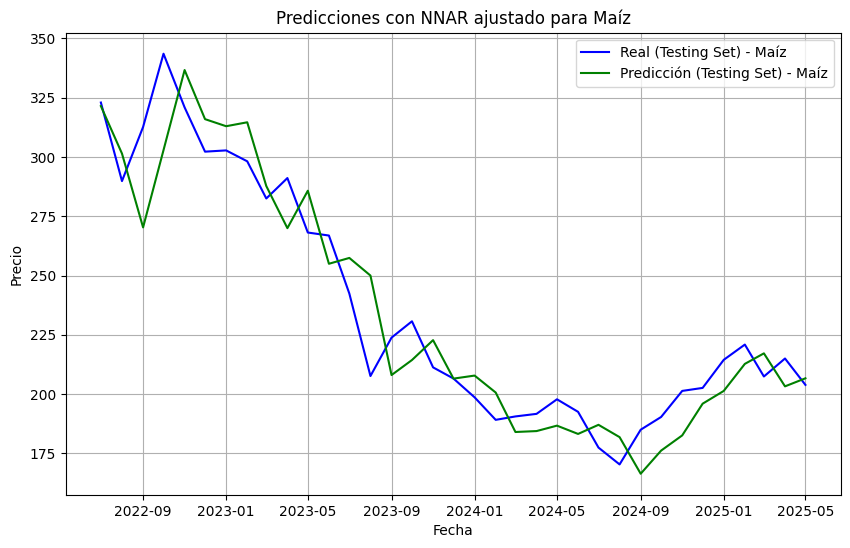

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Resultados para Soja:
MAE: 24.01878812060532
RMSE: 31.003467585502314
MAPE: 4.52%


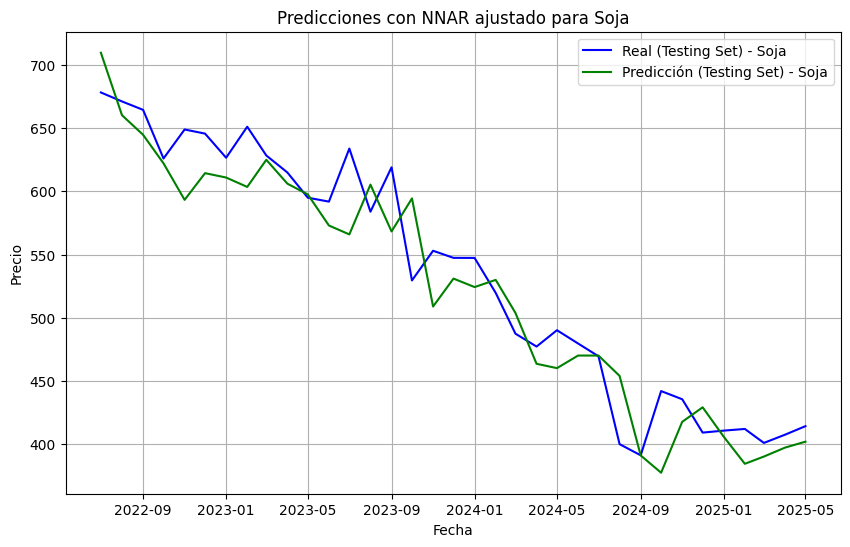

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import os
import random
import tensorflow as tf
import numpy as np

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Cargar los datos
data = load_all()

# Función para crear características y etiquetas para NNAR
def create_lags(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Definir el número de retrasos
n_lags = 12

# Función para entrenar y evaluar el modelo NNAR
def train_and_evaluate_nnar(serie, nombre):
    # Crear las características y etiquetas
    X, y = create_lags(serie.values, n_lags)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Redimensionar los datos para Keras
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))

    # Crear el modelo NNAR
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=n_lags))
    model.add(Dense(1))  # Capa de salida
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Realizar predicciones
    y_pred = model.predict(X_test).flatten()

    # Evaluar el rendimiento
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Resultados para {nombre}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados con fechas reales
    plt.figure(figsize=(10, 6))
    plt.plot(data.index[-len(y_test):], y_test, label=f'Real (Testing Set) - {nombre}', color='blue')
    plt.plot(data.index[-len(y_test):], y_pred, label=f'Predicción (Testing Set) - {nombre}', color='green')
    plt.legend()
    plt.title(f'Predicciones con NNAR ajustado para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar el modelo para Carne, Maíz y Soja
train_and_evaluate_nnar(data['carne'], 'Carne')
train_and_evaluate_nnar(data['maiz'], 'Maíz')
train_and_evaluate_nnar(data['soja'], 'Soja')

#### 3.2.3 LSTM Simple

Este modelo LSTM utiliza una estructura básica con 3 lags como input y 50 neuronas. Está orientado a capturar patrones a corto plazo sin una configuración avanzada de arquitectura o parámetros. Resulta útil como punto de partida para evaluar la capacidad de las redes neuronales en series temporales.


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Resultados para Carne:
MAE: 0.21933103318689515
RMSE: 0.27539284067000375
MAPE: 3.96%


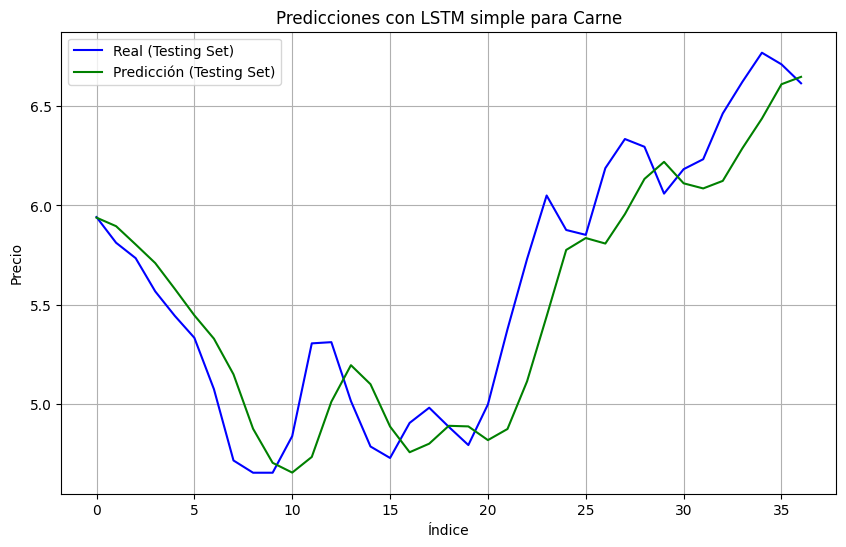

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Resultados para Maíz:
MAE: 12.693813903616016
RMSE: 16.34076548126458
MAPE: 5.43%


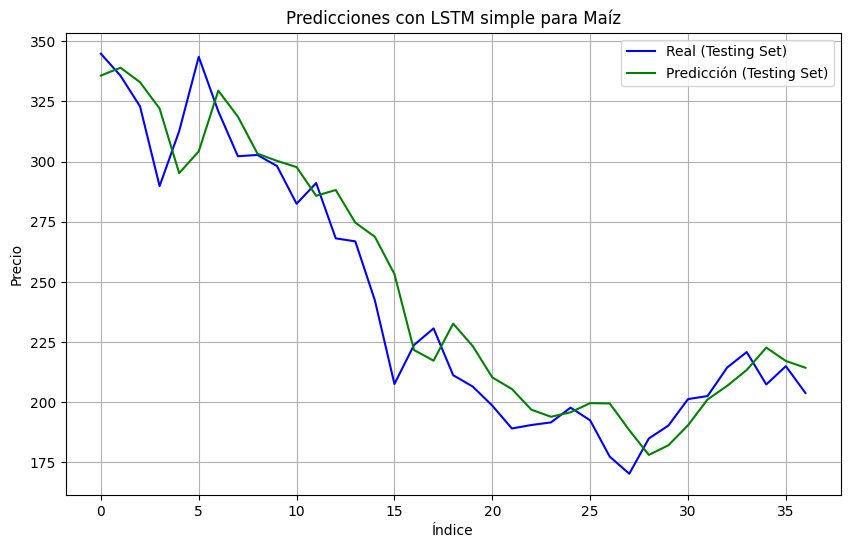

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Resultados para Soja:
MAE: 22.665368135749574
RMSE: 29.838899598639888
MAPE: 4.34%


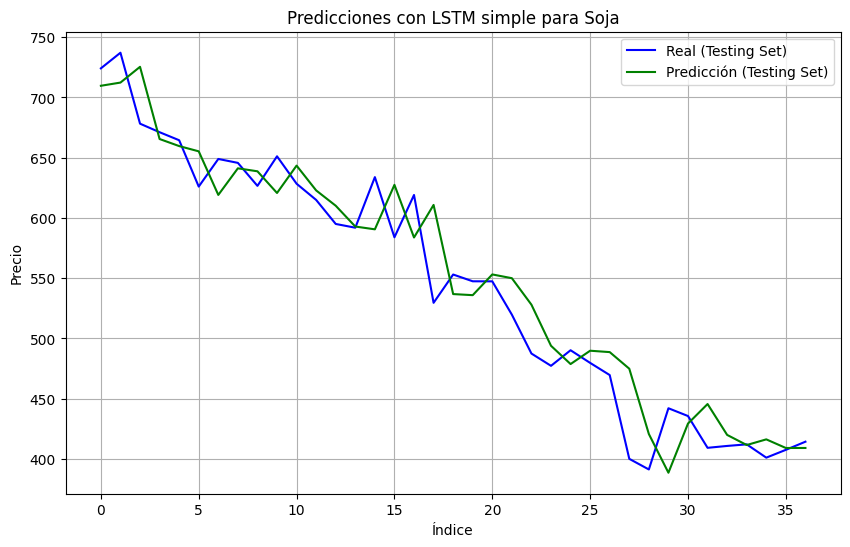

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import numpy as np

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Cargar los datos
data = load_all()

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))

# Función para crear características de series temporales
def create_dataset(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Función para entrenar y evaluar LSTM
def train_and_evaluate_lstm(data_series, nombre_serie, look_back=3):
    # Normalizar los datos
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))

    # Crear conjunto de datos para LSTM
    X, y = create_dataset(scaled_data, look_back)

    # Dividir en Train y Test
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Remodelar datos para LSTM (agregar dimensión para la secuencia)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predicciones
    y_pred = model.predict(X_test)

    # Invertir la escala para y_test y y_pred
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler.inverse_transform(y_pred)

    # Evaluar el rendimiento
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Resultados para {nombre_serie}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, label='Real (Testing Set)', color='blue')
    plt.plot(range(len(y_test)), y_pred, label='Predicción (Testing Set)', color='green')
    plt.legend()
    plt.title(f'Predicciones con LSTM simple para {nombre_serie}')
    plt.xlabel('Índice')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar LSTM para cada commodity
train_and_evaluate_lstm(data['carne'], 'Carne')
train_and_evaluate_lstm(data['maiz'], 'Maíz')
train_and_evaluate_lstm(data['soja'], 'Soja')

#### 3.2.4 LSTM Ajustado

Esta versión ajustada del modelo LSTM aumenta la profundidad de memoria al utilizar 12 lags como entrada y un batch size menor para una mayor frecuencia de actualización del gradiente. Está pensada para capturar relaciones temporales más complejas y mejorar la precisión frente a la versión simple.

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Resultados para Carne:
MAE: 0.15913020324386384
RMSE: 0.18914739912662099
MAPE: 2.90%


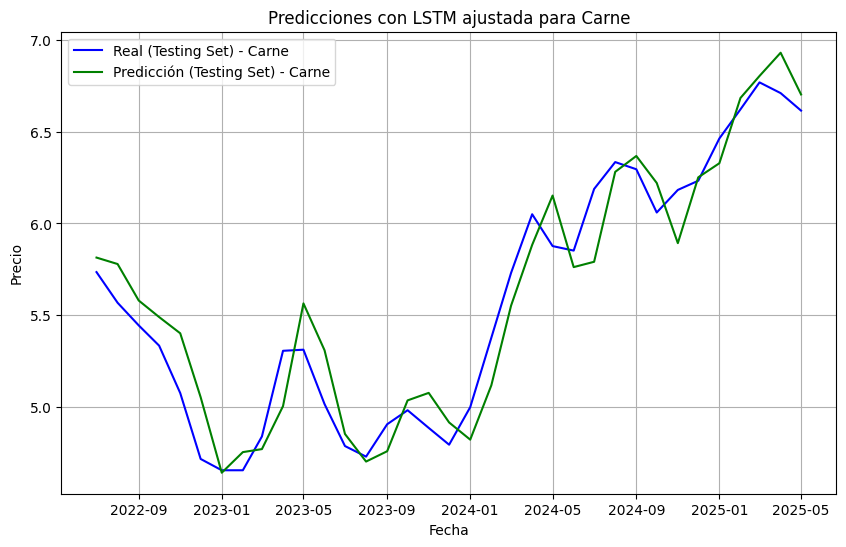

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 998ms/step
Resultados para Maíz:
MAE: 13.0134681794671
RMSE: 16.41005280398647
MAPE: 5.36%


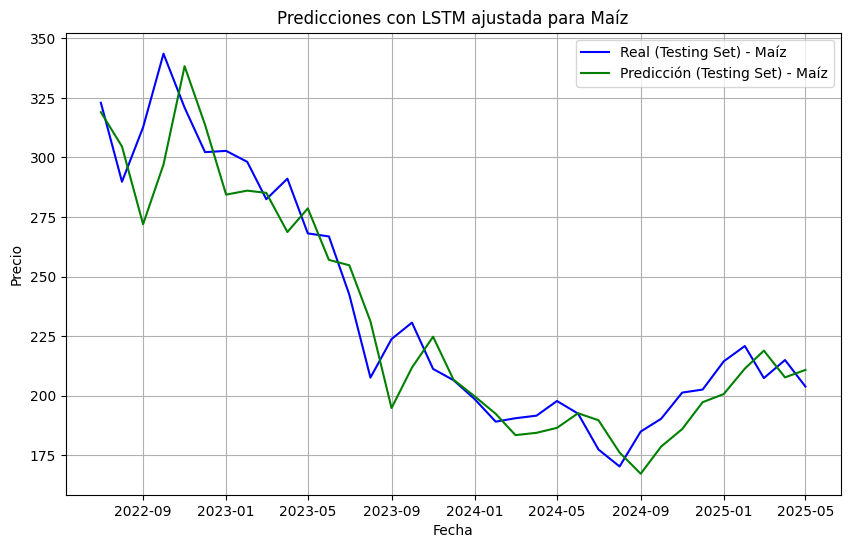

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
Resultados para Soja:
MAE: 24.232599539411115
RMSE: 32.09839894994332
MAPE: 4.55%


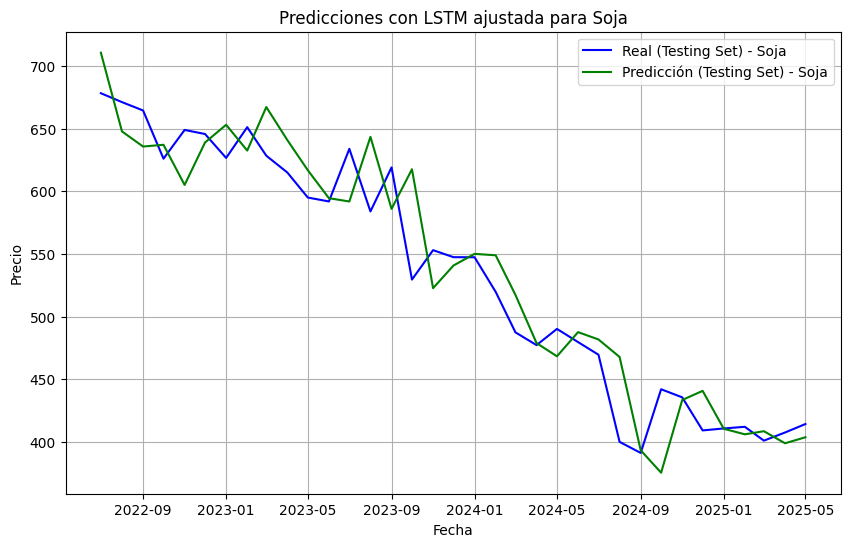

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import os
import random
import tensorflow as tf
import numpy as np

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Cargar los datos
data = load_all()

# Función para crear características y etiquetas para LSTM
def create_lags_lstm(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Definir el número de retrasos
n_lags = 12

# Función para entrenar y evaluar LSTM
def train_and_evaluate_lstm(serie, nombre):
    # Escalar los datos entre 0 y 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1))

    # Crear las características y etiquetas
    X, y = create_lags_lstm(serie_scaled, n_lags)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Redimensionar los datos para LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Crear el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_lags, 1)))
    model.add(Dense(1))  # Capa de salida
    model.compile(optimizer='adam', loss='mse')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    # Realizar predicciones
    y_pred = model.predict(X_test).flatten()

    # Invertir la escala de los datos
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

   # Evaluar el rendimiento
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Resultados para {nombre}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados con fechas reales
    plt.figure(figsize=(10, 6))
    plt.plot(serie.index[-len(y_test):], y_test, label=f'Real (Testing Set) - {nombre}', color='blue')
    plt.plot(serie.index[-len(y_test):], y_pred, label=f'Predicción (Testing Set) - {nombre}', color='green')
    plt.legend()
    plt.title(f'Predicciones con LSTM ajustada para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar el modelo para Carne, Maíz y Soja
train_and_evaluate_lstm(data['carne'], 'Carne')
train_and_evaluate_lstm(data['maiz'], 'Maíz')
train_and_evaluate_lstm(data['soja'], 'Soja')

#### 3.2.5 MLP Regressor

Resultados para Carne:
MAE: 0.6861660677916778
RMSE: 0.8308067067449437
MAPE: 13.19%


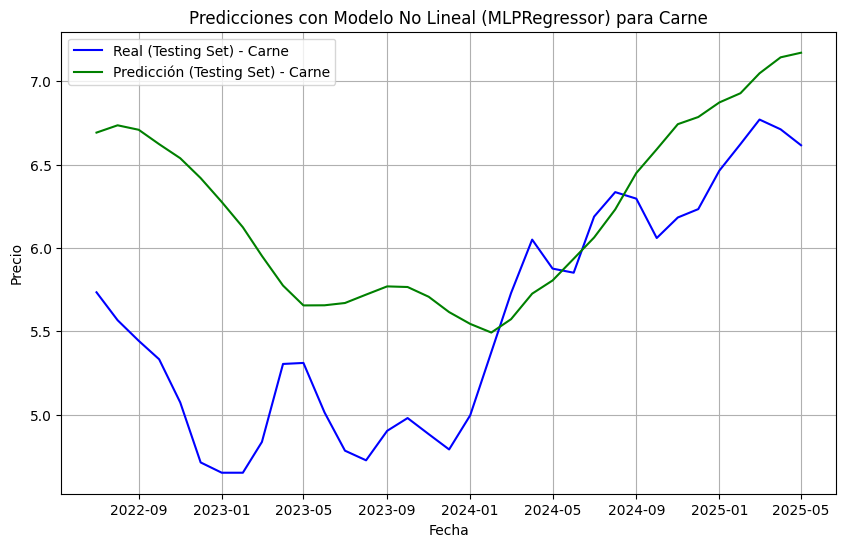

Resultados para Maíz:
MAE: 48.94160009461915
RMSE: 56.26063137699555
MAPE: 21.45%


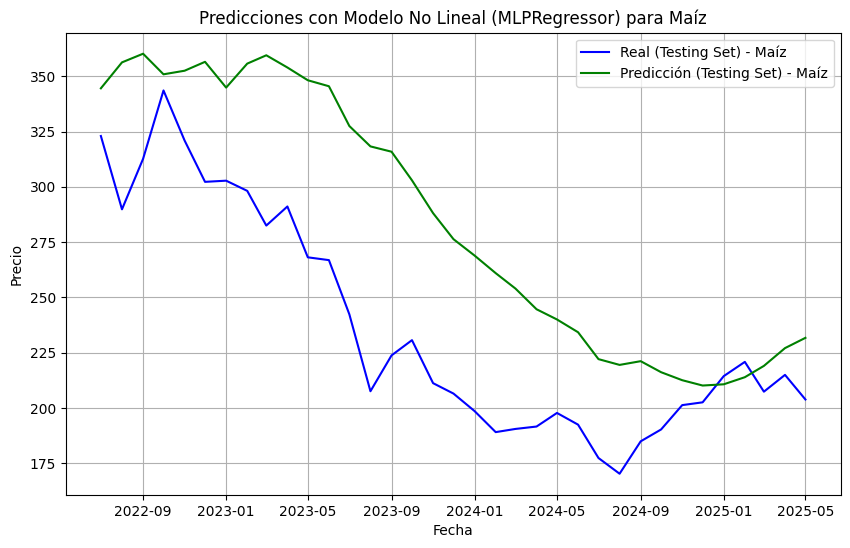

Resultados para Soja:
MAE: 112.62807586530289
RMSE: 116.59577386008054
MAPE: 21.87%


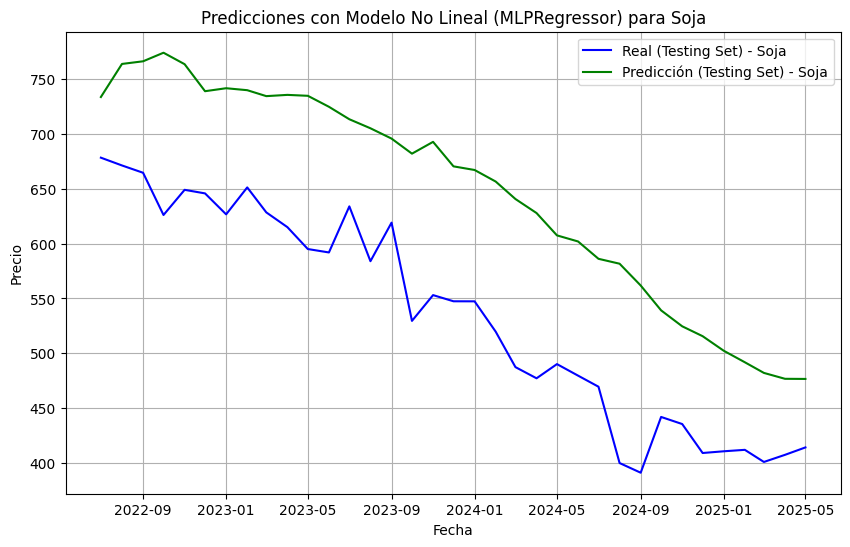

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import random
import tensorflow as tf
import numpy as np

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Cargar los datos
data = load_all()

# Función para crear características de series temporales
def create_lags(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Función para entrenar y evaluar un modelo no lineal
def train_and_evaluate_non_linear(serie, nombre):
    # Crear características y etiquetas
    n_lags = 12
    X, y = create_lags(serie.values, n_lags)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Ajustar el modelo no lineal (MLPRegressor)
    model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
    model.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = model.predict(X_test)

    # Evaluar el rendimiento
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Resultados para {nombre}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar resultados con fechas reales
    plt.figure(figsize=(10, 6))
    plt.plot(serie.index[-len(y_test):], y_test, label=f'Real (Testing Set) - {nombre}', color='blue')
    plt.plot(serie.index[-len(y_test):], y_pred, label=f'Predicción (Testing Set) - {nombre}', color='green')
    plt.legend()
    plt.title(f'Predicciones con Modelo No Lineal (MLPRegressor) para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar el modelo para Carne, Maíz y Soja
train_and_evaluate_non_linear(data['carne'], 'Carne')
train_and_evaluate_non_linear(data['maiz'], 'Maíz')
train_and_evaluate_non_linear(data['soja'], 'Soja')

### 3.2.6 Cuadro Resumen de los Modelos de Redes Neuronales

A continuación, se presentan las métricas de rendimiento (MAE, RMSE y MAPE) obtenidas por cada red neuronal aplicada a los tres commodities: carne, maíz y soja.

**Resultados para Carne:**

| Modelo         | MAE     | RMSE    | MAPE   |
|----------------|---------|---------|--------|
| NNAR simple    | 0.2491  | 0.3105  | 10.31% |
| NNAR ajustado  | 0.2649  | 0.3338  | 4.71%  |
| LSTM simple    | 0.2371  | 0.2928  | 4.37%  |
| LSTM ajustado  | 0.1762  | 0.2157  | 3.25%  |
| MLP Regressor  | 0.7007  | 0.8447  | 13.65% |

**Ganador: LSTM ajustado**

---

**Resultados para Maíz:**

| Modelo         | MAE     | RMSE    | MAPE   |
|----------------|---------|---------|--------|
| NNAR simple    | 17.0682 | 21.9873 | 25.65% |
| NNAR ajustado  | 14.0486 | 17.4731 | 5.34%  |
| LSTM simple    | 14.7998 | 18.5188 | 5.86%  |
| LSTM ajustado  | 14.5267 | 18.0761 | 5.82%  |
| MLP Regressor  | 54.9256 | 60.5709 | 23.20% |

 **Ganador: NNAR ajustado**

---

**Resultados para Soja:**

| Modelo         | MAE     | RMSE    | MAPE   |
|----------------|---------|---------|--------|
| NNAR simple    | 31.4036 | 40.9195 | 16.63% |
| NNAR ajustado  | 37.8945 | 45.7644 | 6.79%  |
| LSTM simple    | 27.3637 | 37.3796 | 4.80%  |
| LSTM ajustado  | 29.3533 | 36.2339 | 5.01%  |
| MLP Regressor  | 112.2001| 119.4924| 20.35% |

 **Ganador: LSTM simple**


### 3.3 📈 Modelos Estadísticos 

En esta sección se emplea un modelo lineal generalizado (GLM), útil como punto de partida o comparación base.

 **GLM (Generalized Linear Model):**
  Modelo de regresión lineal generalizado. Se utiliza aquí como una línea base para comparar con enfoques más complejos.

- **ARIMA (AutoRegressive Integrated Moving Average):**
  Modelo clásico que combina componentes autorregresivos, promedios móviles y diferenciación para capturar tendencias y patrones temporales.

- **SARIMA (Seasonal ARIMA):**
  Extensión de ARIMA que incorpora componentes estacionales. Ideal para series con patrones que se repiten en ciclos regulares (ej. mensuales, anuales).


#### 3.3.1 GLM Gaussiano

Utiliza regresión lineal simple o con términos polinómicos para capturar relaciones lineales entre los precios y sus retardos.

Resultados para Carne:
MAE: 0.14618912564225708
RMSE: 0.1838066303985297
MAPE: 2.61%


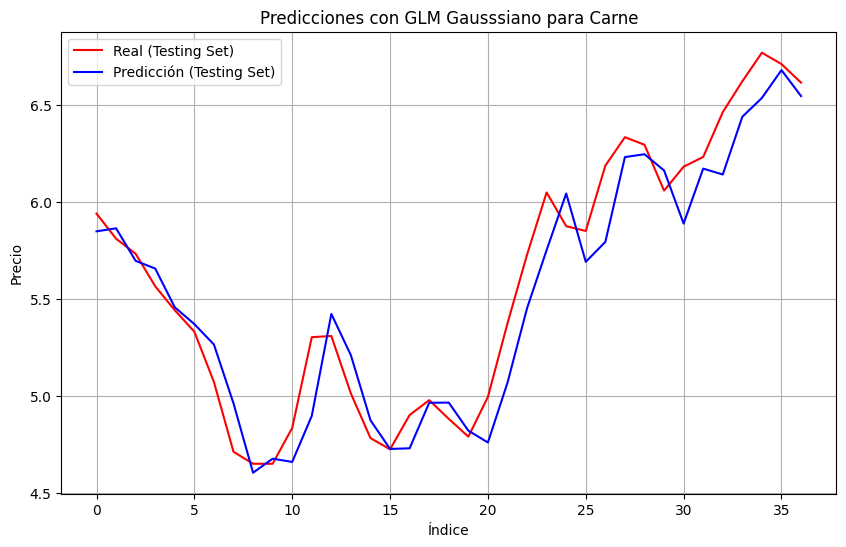

Resultados para Maíz:
MAE: 12.068095132742368
RMSE: 15.310247492662082
MAPE: 4.95%


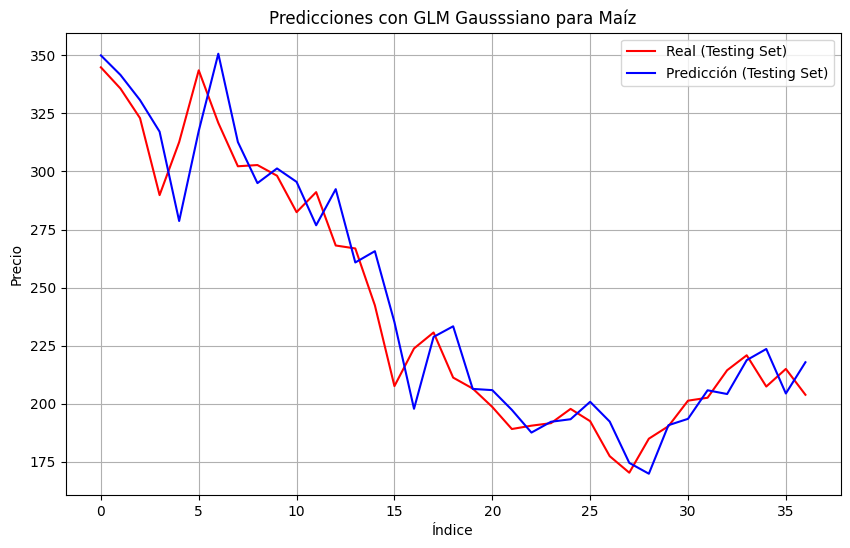

Resultados para Soja:
MAE: 22.650175298747765
RMSE: 31.2243960411304
MAPE: 4.26%


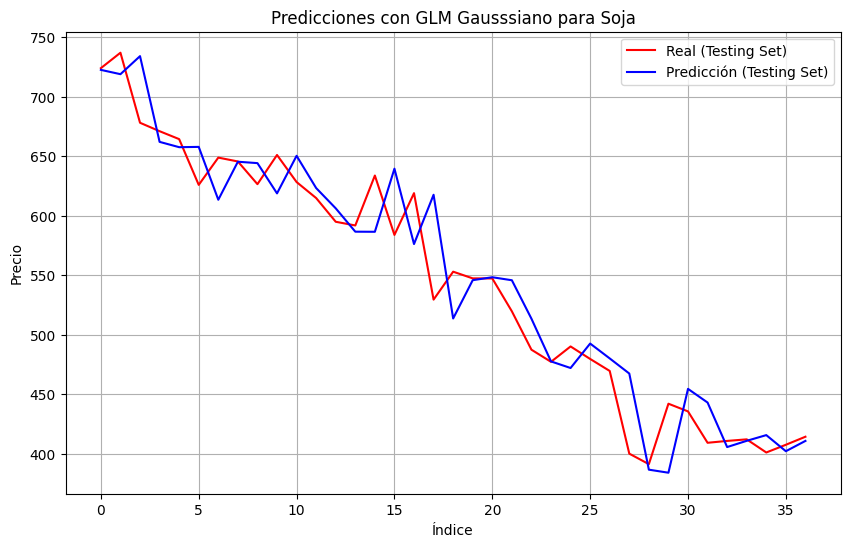

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Cargar los datos
data = load_all()

# Crear características de series temporales (usando retrasos)
def create_features(data, n_lags=3):
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    df['target'] = data
    return df.dropna()

# Crear características para cada commodity
df_carne = create_features(data['carne'])
df_maiz = create_features(data['maiz'])
df_soja = create_features(data['soja'])

# Función para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función para entrenar y evaluar GLM
def train_and_evaluate_glm(df_features, nombre_serie, degree=1):
    # Dividir en Train y Test
    X = df_features.drop(columns=['target']).values
    y = df_features['target'].values
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Transformar características para incluir términos polinómicos
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Ajustar el modelo GLM (Regresión Lineal con términos polinómicos)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predicciones
    y_pred = model.predict(X_test_poly)

    # Evaluar el rendimiento
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Resultados para {nombre_serie}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, label='Real (Testing Set)', color='red')
    plt.plot(range(len(y_test)), y_pred, label='Predicción (Testing Set)', color='blue')
    plt.legend()
    plt.title(f'Predicciones con GLM Gausssiano para {nombre_serie}')
    plt.xlabel('Índice')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar GLM para cada commodity
train_and_evaluate_glm(df_carne, 'Carne', degree=1)
train_and_evaluate_glm(df_maiz, 'Maíz', degree=1)
train_and_evaluate_glm(df_soja, 'Soja', degree=1)

RidgeCV + Lags12 + MA3 + Mes (MAÍZ):
  MAE  = 14.74
  RMSE = 15.70
  MAPE = 7.83%


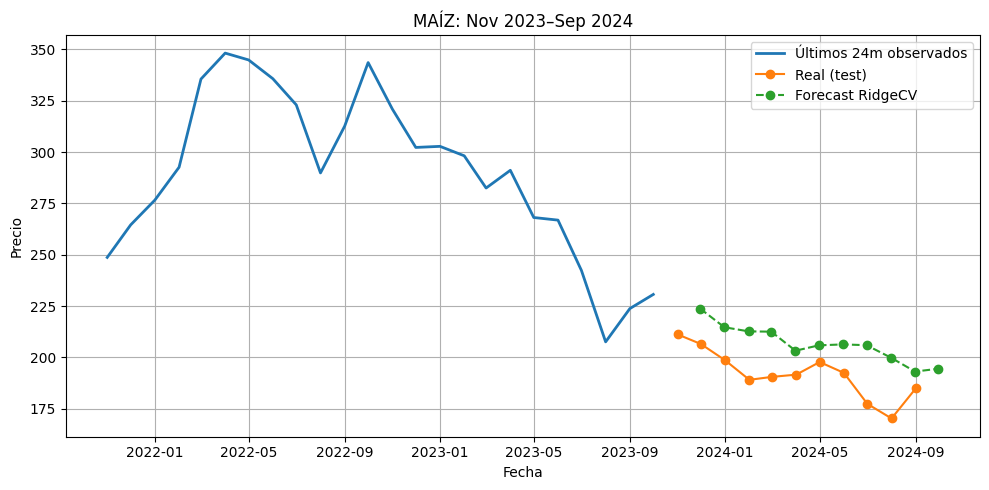

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

# 1) Carga
data  = load_all()
serie = data['maiz']

# 2) Features: lags, MA3 y mes
MAX_LAG = 12
df = pd.DataFrame({'y': serie})
for lag in range(1, MAX_LAG+1):
    df[f'lag_{lag}'] = df['y'].shift(lag)
df['ma_3']  = df['y'].rolling(3).mean().shift(1)
df['month'] = df.index.month
df = df.dropna()

# 3) Train/Test split
train_end = pd.to_datetime("2023-09-30")
df_train  = df.loc[:train_end]
df_test   = df.loc[train_end + MonthEnd(1):]
H         = len(df_test)

X_train, y_train = df_train.drop(columns='y'), df_train['y']
X_test,  y_test  = df_test.drop(columns='y'),    df_test['y']

# 4) Pipeline + RidgeCV
preproc = ColumnTransformer([
    ('ohe_month', OneHotEncoder(drop='first'), ['month']),
], remainder='passthrough')

model = make_pipeline(
    preproc,
    RidgeCV(
      alphas=[0.1,1,10,100],
      scoring='neg_root_mean_squared_error',
      cv=4
    )
)
model.fit(X_train, y_train)

# 5) Forecast recursivo
history   = df_train.copy()
last_vals = df_train['y'].values[-MAX_LAG:]
preds     = []

for _ in range(H):
    next_date = history.index[-1] + MonthEnd(1)
    row = {f'lag_{i}': last_vals[-i] for i in range(1, MAX_LAG+1)}
    row['ma_3']  = history['y'].rolling(3).mean().iloc[-1]
    row['month'] = next_date.month
    X_row = pd.DataFrame([row], index=[next_date])
    y_hat = model.predict(X_row)[0]
    preds.append(y_hat)
    last_vals = np.append(last_vals[1:], y_hat)
    history.loc[next_date, 'y'] = y_hat

# 6) Métricas
mae  = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = np.mean(np.abs((y_test - preds)/y_test))*100

print("RidgeCV + Lags12 + MA3 + Mes (MAÍZ):")
print(f"  MAE  = {mae:0.2f}")
print(f"  RMSE = {rmse:0.2f}")
print(f"  MAPE = {mape:0.2f}%")

# 7) Gráfico
plt.figure(figsize=(10,5))
hist_start = df_test.index[0] - pd.DateOffset(months=24)
plt.plot(
    serie.loc[hist_start:df_test.index[0]-MonthEnd(1)],
    label='Últimos 24m observados', lw=2
)
plt.plot(df_test.index, y_test.values, 'o-', label='Real (test)')
fut_dates = pd.date_range(df_test.index[0], periods=H, freq='M')
plt.plot(fut_dates, preds, 'o--', label='Forecast RidgeCV')
plt.title(f"MAÍZ: {df_test.index[0].strftime('%b %Y')}–"
          f"{fut_dates[-1].strftime('%b %Y')}")
plt.xlabel("Fecha"); plt.ylabel("Precio")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


#### 3.3.2 GLM Poisson

Aunque suele aplicarse a conteos, se utilizó aquí para modelar series temporales de precios positivos, aprovechando su estructura aditiva y su capacidad para capturar relaciones no lineales suaves.

Resultados para Carne:
MAE: 0.1712460420777853
RMSE: 0.22167846166985303
MAPE: 3.10%


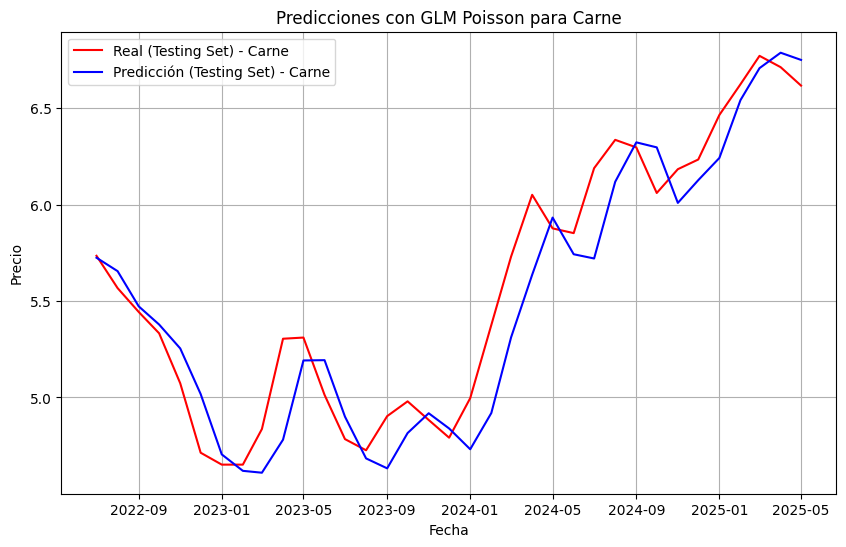

Resultados para Maíz:
MAE: 40.35004642529042
RMSE: 54.97457184031517
MAPE: 15.18%


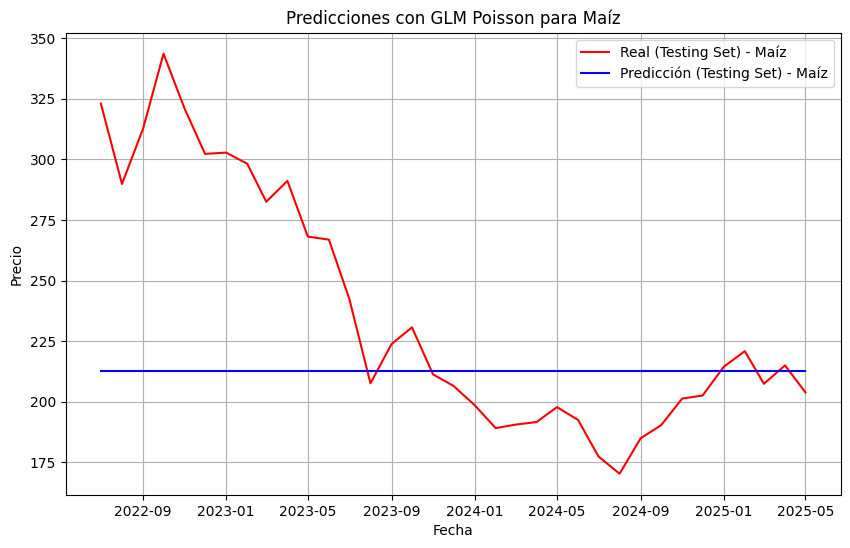

Resultados para Soja:
MAE: 95.52770532173575
RMSE: 112.71395719467523
MAPE: 16.90%


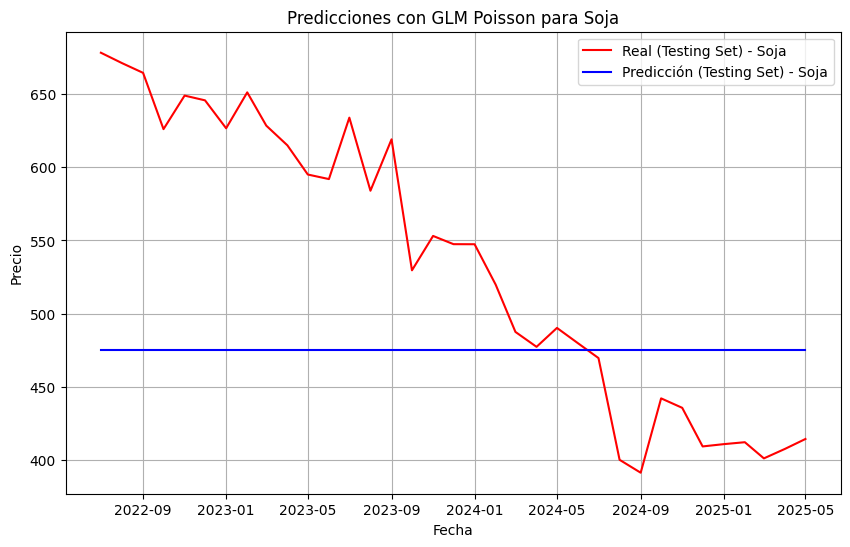

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Cargar los datos
data = load_all()

# Función para crear características y etiquetas
def create_lags(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Definir el número de retrasos
n_lags = 12

# Función para entrenar y evaluar el modelo GLM
def train_and_evaluate_glm(serie, nombre):
    # Crear características y etiquetas
    X, y = create_lags(serie.values, n_lags)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Aplanar las características para GLM (porque PoissonRegressor no acepta tensores)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

    # Ajustar el modelo GLM
    model = PoissonRegressor(alpha=0.1, max_iter=1000)
    model.fit(X_train, y_train)

    # Realizar predicciones
    y_pred = model.predict(X_test)

    # Evaluar el rendimiento del modelo
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f'Resultados para {nombre}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar los resultados con fechas reales
    plt.figure(figsize=(10, 6))
    plt.plot(serie.index[-len(y_test):], y_test, label=f'Real (Testing Set) - {nombre}', color='red')
    plt.plot(serie.index[-len(y_test):], y_pred, label=f'Predicción (Testing Set) - {nombre}', color='blue')
    plt.legend()
    plt.title(f'Predicciones con GLM Poisson para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar el modelo para Carne, Maíz y Soja
train_and_evaluate_glm(data['carne'], 'Carne')
train_and_evaluate_glm(data['maiz'], 'Maíz')
train_and_evaluate_glm(data['soja'], 'Soja')

#### 3.3.3 ARIMA

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para Carne:
MAE: 0.6338651419864891
RMSE: 0.7484185224539422
MAPE: 12.12%


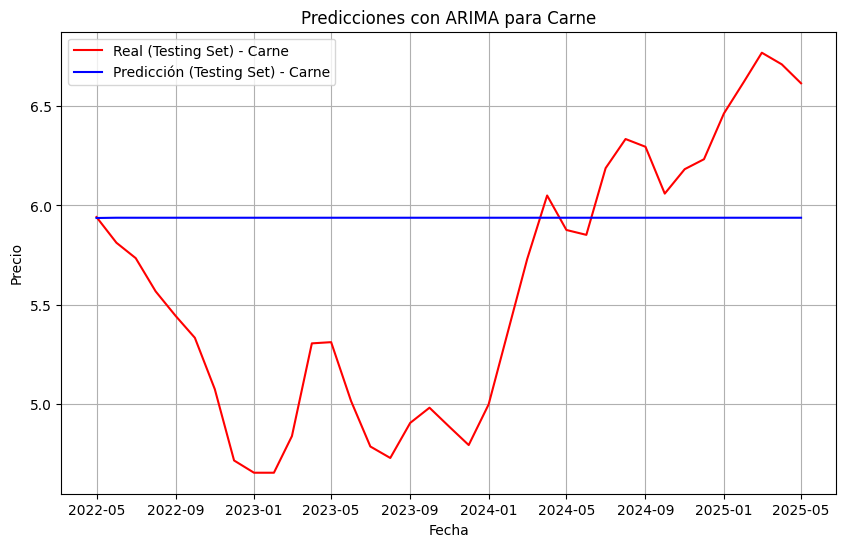

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para Maíz:
MAE: 110.99377181066305
RMSE: 123.34208244952197
MAPE: 52.71%


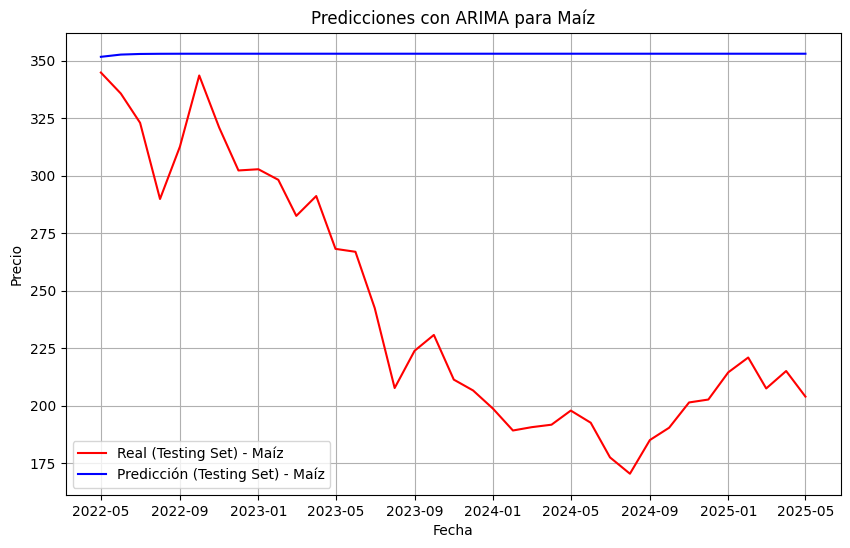

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para Soja:
MAE: 185.24604826560682
RMSE: 211.76658771690512
MAPE: 39.07%


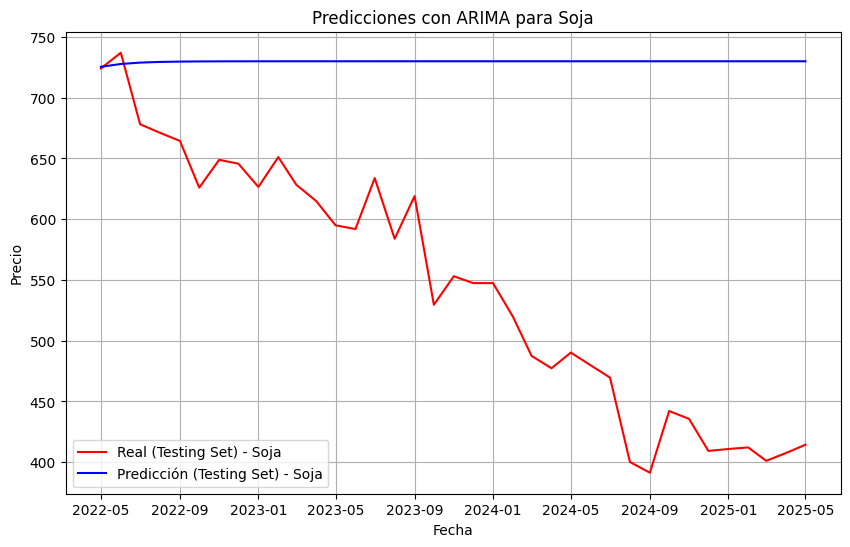

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Cargar los datos
data = load_all()

# Función para entrenar y evaluar ARIMA
def train_and_evaluate_arima(serie, nombre, order=(1, 1, 1)):
    # Dividir en entrenamiento y prueba
    train_size = int(len(serie) * 0.8)
    train, test = serie.iloc[:train_size], serie.iloc[train_size:]

    # Ajustar modelo ARIMA
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Predecir el mismo período que el test
    predictions = model_fit.forecast(steps=len(test))

    # Calcular métricas
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mape = np.mean(np.abs((test - predictions) / test)) * 100

    print(f"Resultados para {nombre}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape:.2f}%")

    # Gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test, label=f'Real (Testing Set) - {nombre}', color='red')
    plt.plot(test.index, predictions, label=f'Predicción (Testing Set) - {nombre}', color='blue')
    plt.legend()
    plt.title(f'Predicciones con ARIMA para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Aplicar a tus series
train_and_evaluate_arima(data['carne'], 'Carne', order=(1, 1, 1))
train_and_evaluate_arima(data['maiz'], 'Maíz', order=(1, 1, 1))
train_and_evaluate_arima(data['soja'], 'Soja', order=(1, 1, 1))


#### 3.3.4 SARIMA

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para Carne:
MAE: 0.7235777776586955
RMSE: 0.8770423939191297
MAPE: 14.12%


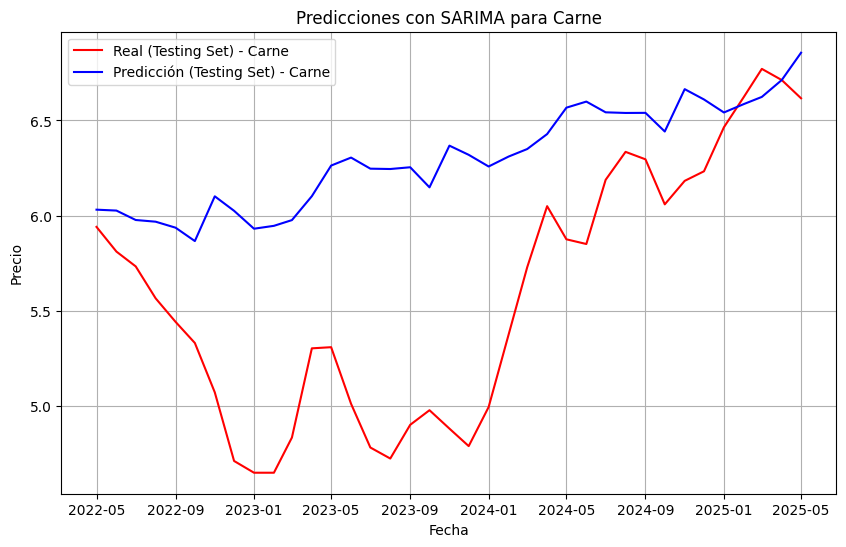

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para Maíz:
MAE: 124.86373470123365
RMSE: 141.13217821575915
MAPE: 59.67%


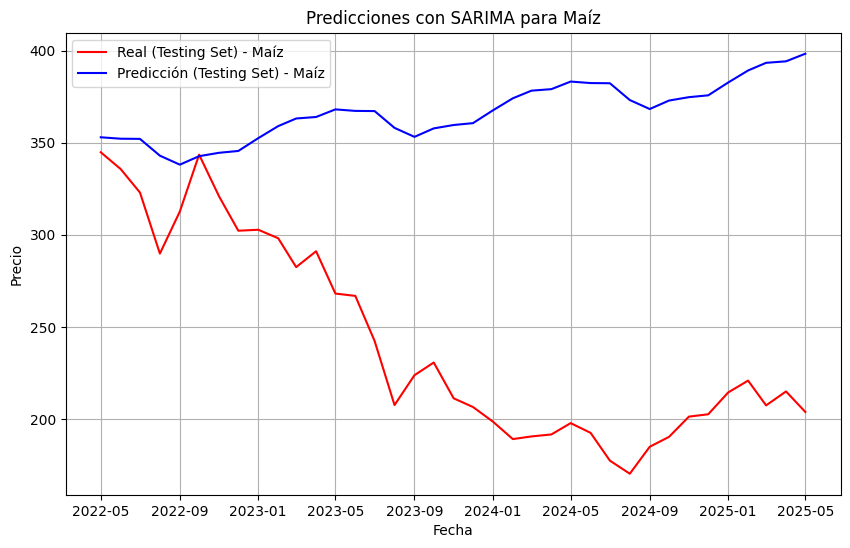

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resultados para Soja:
MAE: 219.98352202437633
RMSE: 253.71300970460746
MAPE: 46.56%


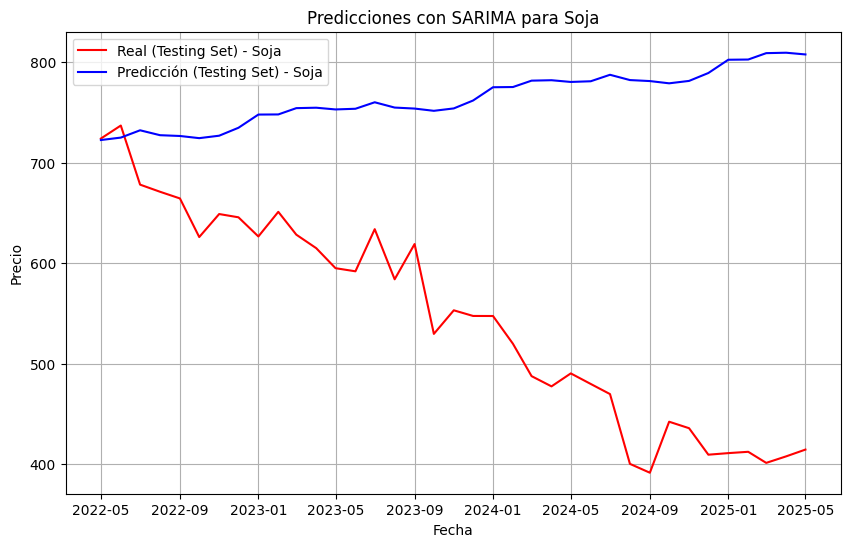

In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Cargar los datos
data = load_all()

# Función para entrenar y evaluar un modelo de espacio de estados
def train_and_evaluate_statespace(serie, nombre):
    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(serie) * 0.8)
    train, test = serie.iloc[:train_size], serie.iloc[train_size:]

    # Ajustar un modelo SARIMAX como ejemplo de espacio de estados
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # Realizar predicciones
    predictions = model_fit.forecast(steps=len(test))

    # Calcular métricas
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mape = np.mean(np.abs((test - predictions) / test)) * 100

    print(f'Resultados para {nombre}:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')

    # Graficar resultados con fechas reales
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test, label=f'Real (Testing Set) - {nombre}', color='red')
    plt.plot(test.index, predictions, label=f'Predicción (Testing Set) - {nombre}', color='blue')
    plt.legend()
    plt.title(f'Predicciones con SARIMA para {nombre}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

# Probar el modelo para Carne, Maíz y Soja
train_and_evaluate_statespace(data['carne'], 'Carne')
train_and_evaluate_statespace(data['maiz'], 'Maíz')
train_and_evaluate_statespace(data['soja'], 'Soja')

### 3.3.5 Cuadro Resumen de Modelos Estadísticos

A continuación se presentan los resultados de las métricas para cada uno de los modelos estadísticos aplicados a los tres commodities: carne, maíz y soja.

**Resultados para Carne:**

| Modelo        | MAE    | RMSE   | MAPE   |
|---------------|--------|--------|--------|
| GLM Gaussiano | 0.1505 | 0.1935 | 2.73%  |
| GLM Poisson   | 0.1669 | 0.2285 | 3.07%  |
| ARIMA         | 0.5072 | 0.6367 | 10.01% |
| SARIMA        | 0.8724 | 1.0255 | 16.99% |

**Ganador: GLM Gaussiano**

---

**Resultados para Maíz:**

| Modelo        | MAE     | RMSE    | MAPE   |
|---------------|---------|---------|--------|
| GLM Gaussiano | 13.1579 | 16.7406 | 5.08%  |
| GLM Poisson   | 62.1494 | 77.3377 | 21.37% |
| ARIMA         | 53.4940 | 62.7300 | 19.75% |
| SARIMA        | 56.6501 | 64.8591 | 22.65% |

 **Ganador: GLM Gaussiano**

---

**Resultados para Soja:**

| Modelo        | MAE     | RMSE     | MAPE   |
|---------------|---------|----------|--------|
| GLM Gaussiano | 24.6547 | 32.5669  | 4.25%  |
| GLM Poisson   | 135.7085| 155.7677 | 21.56% |
| ARIMA         | 80.0893 | 96.9495  | 13.47% |
| SARIMA        | 79.6322 | 96.6846  | 14.07% |

**Ganador: GLM Gaussiano**


## 4. ⚙️ AutoML 

Finalmente, se utilizan herramientas de **AutoML** para automatizar la evaluación de múltiples enfoques de forecasting y seleccionar el modelo más adecuado.

### Herramientas utilizadas:

- **AutoTS:** ejecuta pruebas automáticas con diferentes modelos (estacionarios y no estacionarios), selecciona el mejor según métricas y entrega predicciones a futuro.
- **AutoGluon:** una biblioteca de AutoML desarrollada por Amazon que permite entrenar modelos de forma automática para tareas de clasificación, regresión y series temporales, optimizando hiperparámetros y seleccionando el mejor pipeline de forma eficiente.

> Estas herramientas permiten validar rápidamente el rendimiento de enfoques alternativos sin necesidad de construir cada modelo desde cero.



### 4.1 AutoTS

**AutoTS para la Carne**

In [ ]:
!pip install autots==0.6.7


  Using cached autots-0.6.7-py3-none-any.whl.metadata (10.0 kB)
  Using cached numpy-2.3.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached autots-0.6.7-py3-none-any.whl (821 kB)
Using cached numpy-2.3.1-cp311-cp311-win_amd64.whl (13.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: autots
    Found existing installation: autots 0.6.21
    Uninstalling autots-0.6.21:
      Successfully uninstalled autots-0.6.21


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.3.1 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.3.1 which is incompatible.
datasets 2.21.0 requires pyarrow>=15.0.0, but you have pyarrow 14.0.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
matplotlib 3.7.5 requires numpy<2,>=1.20, but you have numpy 2.3.1 which is incompatible.
mljar-supervised 1.1.17 requires numpy<2,>=1.19.5, but you have numpy 2.3.1 which is incompatible.
mljar-supervised 1.1.17 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
mljar-supervised 1.1

Data frequency is: MS, used frequency is: MS
Model Number: 1 with model ETS in generation 0 of 10
Model Number: 2 with model ETS in generation 0 of 10
Model Number: 3 with model GLM in generation 0 of 10
Model Number: 4 with model SeasonalNaive in generation 0 of 10
Model Number: 5 with model AverageValueNaive in generation 0 of 10
Model Number: 6 with model ConstantNaive in generation 0 of 10
Model Number: 7 with model ETS in generation 0 of 10
Model Number: 8 with model ConstantNaive in generation 0 of 10
Model Number: 9 with model GLM in generation 0 of 10
Model Number: 10 with model DatepartRegression in generation 0 of 10
Model Number: 11 with model ConstantNaive in generation 0 of 10
Model Number: 12 with model SectionalMotif in generation 0 of 10
Model Number: 13 with model GLS in generation 0 of 10
Model Number: 14 with model AverageValueNaive in generation 0 of 10
New Generation: 1 of 10
Model Number: 15 with model ConstantNaive in generation 1 of 10
Model Number: 16 with mode

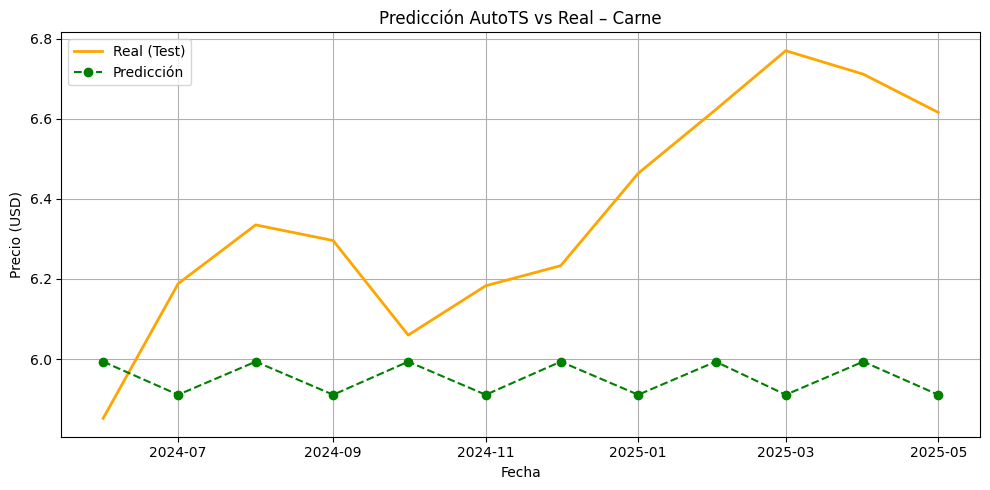

In [ ]:
from src.data import load_all
from autots import AutoTS 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Cargar todo el DataFrame (índice = fecha)
data = load_all()

# 2) Seleccionar la serie de CARNE
serie = data['carne']

# 3) Split tren-test (últimos 12 valores)
forecast_length = 12
df_train = serie[:-forecast_length]
df_test  = serie[-forecast_length:]

# 4) Formato largo para AutoTS
df_autots = (
    df_train.reset_index()
             .rename(columns={'fecha': 'datetime', 'carne': 'value'})
)
df_autots['series_id'] = 'carne'
df_autots = df_autots[['datetime', 'value', 'series_id']]

# 5)  Cargar la plantilla ya guardada  
    forecast_length=forecast_length,   
    frequency='infer',
    ensemble='simple'
).import_template(
    "templates/best_carne.csv",
    method="only"                      
)

# 6) Ajustar SOLO ese pipeline
model = model.fit(
    df_autots,
    date_col='datetime',
    value_col='value',
    id_col='series_id'
)

# 7) Predecir
forecast_df = model.predict().forecast
if 'carne' in forecast_df.index:
    y_pred = forecast_df.loc['carne'].values
elif 'carne' in forecast_df.columns:
    y_pred = forecast_df['carne'].values
else:
    y_pred = forecast_df.values.flatten()

y_true       = df_test.values
fechas_test  = df_test.index

# 8) Métricas
mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("📊 Evaluación AutoTS (plantilla) – Carne")
print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")

# 9) Gráfico
plt.figure(figsize=(10, 5))
plt.plot(fechas_test, y_true, label="Real (Test)",   color='orange', linewidth=2)
plt.plot(fechas_test, y_pred, label="Predicción",    color='green',  linestyle='--', marker='o')
plt.title("Predicción AutoTS vs Real – Carne")
plt.xlabel("Fecha"); plt.ylabel("Precio (USD)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



In [ ]:
print(" Mejor modelo seleccionado por AutoTS:")
print(model.best_model)


📌 Mejor modelo seleccionado por AutoTS:
                                 ID Model  \
1  0080ca23096e1df1987a064f0c924df2   ETS   

                                     ModelParameters  \
1  {"damped_trend": false, "trend": null, "season...   

                            TransformationParameters  Ensemble  
1  {"fillna": "quadratic", "transformations": {"0...         0  


 **AutoTS para el Maíz**


Data frequency is: MS, used frequency is: MS
Model Number: 1 with model GLS in generation 0 of 10
Model Number: 2 with model GLS in generation 0 of 10
Model Number: 3 with model NVAR in generation 0 of 10
Model Number: 4 with model SeasonalNaive in generation 0 of 10
Model Number: 5 with model ETS in generation 0 of 10
Model Number: 6 with model ETS in generation 0 of 10
Model Number: 7 with model ConstantNaive in generation 0 of 10
Model Number: 8 with model ETS in generation 0 of 10
Model Number: 9 with model DatepartRegression in generation 0 of 10
Model Number: 10 with model ConstantNaive in generation 0 of 10
Model Number: 11 with model SectionalMotif in generation 0 of 10
Model Number: 12 with model SectionalMotif in generation 0 of 10
New Generation: 1 of 10
Model Number: 13 with model SectionalMotif in generation 1 of 10
Model Number: 14 with model SectionalMotif in generation 1 of 10
Model Number: 15 with model SectionalMotif in generation 1 of 10
Template Eval Error: Exceptio

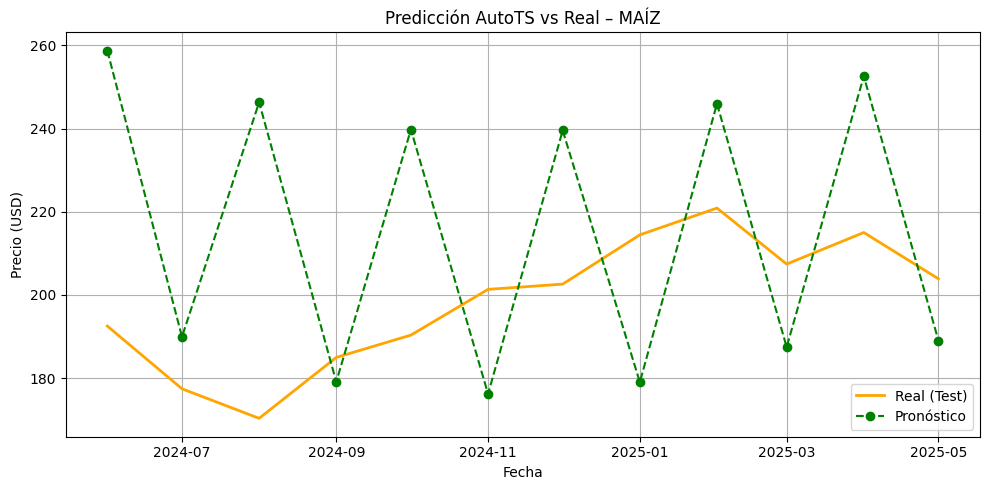

In [ ]:
from src.data import load_all
from autots import AutoTS
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Cargar el DataFrame completo (índice = fecha)
data = load_all()

# 2) Seleccionar la serie de MAÍZ
serie = data['maiz']

# 3) Split tren-test (últimos 12 valores)
forecast_length = 12
df_train = serie[:-forecast_length]
df_test  = serie[-forecast_length:]

# 4) Formato largo para AutoTS
df_autots = (
    df_train.reset_index()
             .rename(columns={'fecha': 'datetime', 'maiz': 'value'})
)
df_autots['series_id'] = 'maiz'
df_autots = df_autots[['datetime', 'value', 'series_id']]

# 5) Cargar la PLANTILLA  
model_maiz = AutoTS(
    forecast_length=forecast_length,
    frequency='infer',
    ensemble='simple'
).import_template(
    "templates/best_maiz.csv",
    method="only"  
).fit(
    df_autots,
    date_col='datetime',
    value_col='value',
    id_col='series_id'
)

# 6) Predecir
forecast_df = model_maiz.predict().forecast
if 'maiz' in forecast_df.index:
    y_pred = forecast_df.loc['maiz'].values
elif 'maiz' in forecast_df.columns:
    y_pred = forecast_df['maiz'].values
else:
    y_pred = forecast_df.values.flatten()

y_true      = df_test.values
fechas_test = df_test.index

# 7) Métricas
mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("📊 Evaluación AutoTS (plantilla) – MAÍZ")
print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")

# 8) Gráfico
plt.figure(figsize=(10, 5))
plt.plot(fechas_test, y_true, label="Real (Test)", color='orange', linewidth=2)
plt.plot(fechas_test, y_pred, label="Pronóstico", color='green',
         linestyle='--', marker='o')
plt.title("Predicción AutoTS vs Real – MAÍZ")
plt.xlabel("Fecha"); plt.ylabel("Precio (USD)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()




In [ ]:
print("📌 Mejor modelo AutoTS – Maíz")
print(model_maiz.best_model)



📌 Mejor modelo AutoTS – Maíz
                                 ID Model ModelParameters  \
1  011de9107789a82e4bedc7dfcc519d5b   GLS              {}   

                            TransformationParameters  Ensemble  
1  {"fillna": "zero", "transformations": {"0": "S...         0  


 ***AutoTS para la Soja**

Data frequency is: MS, used frequency is: MS
Model Number: 1 with model LastValueNaive in generation 0 of 10
Model Number: 2 with model MetricMotif in generation 0 of 10
Model Number: 3 with model LastValueNaive in generation 0 of 10
Model Number: 4 with model SectionalMotif in generation 0 of 10
Model Number: 5 with model AverageValueNaive in generation 0 of 10
Model Number: 6 with model AverageValueNaive in generation 0 of 10
Model Number: 7 with model AverageValueNaive in generation 0 of 10
Model Number: 8 with model LastValueNaive in generation 0 of 10
Model Number: 9 with model SectionalMotif in generation 0 of 10
Model Number: 10 with model NVAR in generation 0 of 10
Model Number: 11 with model UnivariateMotif in generation 0 of 10
Model Number: 12 with model AverageValueNaive in generation 0 of 10
Model Number: 13 with model SeasonalNaive in generation 0 of 10
Model Number: 14 with model GLS in generation 0 of 10
Model Number: 15 with model GLS in generation 0 of 10
Model Number

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Model Number: 22 with model LastValueNaive in generation 1 of 10
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 22 in generation 1: LastValueNaive
Model Number: 23 with model UnivariateMotif in generation 1 of 10
Model Number: 24 with model UnivariateMotif in generation 1 of 10
Model Number: 25 with model UnivariateMotif in generation 1 of 10
Model Number: 26 with model SectionalMotif in generation 1 of 10
Template Eval Error: Exception('Transformer ReplaceConstant failed on fit') in model 26 in generation 1: SectionalMotif
Model Number: 27 with model SectionalMotif in generation 1 of 10
Model Number: 28 with model SectionalMotif in generation 1 of 10
Model Number: 29 with model AverageValueNaive in generation 1 of 10
Model Number: 30 with model AverageValueNaive in generation 1 of 10
Model Number: 31 with model AverageValueNaive in generation 1 of 10
Template Eval Error: ValueError('Model failed to return correct number of series.') in model 31 in gen

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 98 with model MetricMotif in generation 2 of 10
Model Number: 99 with model AverageValueNaive in generation 2 of 10
Template Eval Error: ValueError('Model failed to return correct number of series.') in model 99 in generation 2: AverageValueNaive
Model Number: 100 with model AverageValueNaive in generation 2 of 10
Model Number: 101 with model GLS in generation 2 of 10
Model Number: 102 with model GLS in generation 2 of 10
Model Number: 103 with model LastValueNaive in generation 2 of 10
Model Number: 104 with model LastValueNaive in generation 2 of 10
Model Number: 105 with model SectionalMotif in generation 2 of 10
Model Number: 106 with model SectionalMotif in generation 2 of 10
Model Number: 107 with model SeasonalNaive in generation 2 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 107 in generation 2: SeasonalNaive
Model Number: 108 with model SeasonalNaive in generation 2 of 10
Model Number: 109 with model SeasonalNaive in ge

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.63789e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\tools\impute.py:54: RuntimeWarning: Mean of empty slice
  arr = np.nan_to_num(arr) + np.isnan(arr) * np.nan_to_num(np.nanmean(arr, axis=0))


Model Number: 149 with model AverageValueNaive in generation 3 of 10
Model Number: 150 with model AverageValueNaive in generation 3 of 10
Model Number: 151 with model AverageValueNaive in generation 3 of 10
Model Number: 152 with model GLS in generation 3 of 10
Model Number: 153 with model GLS in generation 3 of 10
Model Number: 154 with model GLS in generation 3 of 10
Model Number: 155 with model SeasonalNaive in generation 3 of 10
Model Number: 156 with model SeasonalNaive in generation 3 of 10
Model Number: 157 with model SeasonalNaive in generation 3 of 10
Model Number: 158 with model MetricMotif in generation 3 of 10
Model Number: 159 with model MetricMotif in generation 3 of 10
Model Number: 160 with model MetricMotif in generation 3 of 10
Model Number: 161 with model GLS in generation 3 of 10
Model Number: 162 with model GLS in generation 3 of 10
Model Number: 163 with model MetricMotif in generation 3 of 10
Model Number: 164 with model MetricMotif in generation 3 of 10
Template

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.63789e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



Model Number: 176 with model MetricMotif in generation 3 of 10
Template Eval Error: Exception('Transformer ReplaceConstant failed on fit') in model 176 in generation 3: MetricMotif
Model Number: 177 with model MetricMotif in generation 3 of 10
Model Number: 178 with model SectionalMotif in generation 3 of 10
Model Number: 179 with model SectionalMotif in generation 3 of 10
Template Eval Error: Exception('Transformer SeasonalDifference failed on fit') in model 179 in generation 3: SectionalMotif
Model Number: 180 with model SeasonalNaive in generation 3 of 10
Model Number: 181 with model SeasonalNaive in generation 3 of 10
Model Number: 182 with model GLS in generation 3 of 10
Model Number: 183 with model GLS in generation 3 of 10
Model Number: 184 with model UnivariateMotif in generation 3 of 10


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 185 with model UnivariateMotif in generation 3 of 10
Model Number: 186 with model GLS in generation 3 of 10
Model Number: 187 with model SectionalMotif in generation 3 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 187 in generation 3: SectionalMotif
Model Number: 188 with model SectionalMotif in generation 3 of 10
Template Eval Error: ValueError('Unknown Distance Metric: kulsinski') in model 188 in generation 3: SectionalMotif
Model Number: 189 with model SectionalMotif in generation 3 of 10
Model Number: 190 with model GLS in generation 3 of 10
Model Number: 191 with model GLS in generation 3 of 10
Model Number: 192 with model UnivariateMotif in generation 3 of 10
Model Number: 193 with model UnivariateMotif in generation 3 of 10
Model Number: 194 with model LastValueNaive in generation 3 of 10
Model Number: 195 with model ETS in generation 3 of 10
Model Number: 196 with model NVAR in generation 3 of 10
Model Number: 197 wi

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\tools\fast_kalman.py:1089: RuntimeWarning: overflow encountered in cast
  result.smoothed.states.cov[:, j, :, :] = Ps
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\tools\fast_kalman.py:1095: RuntimeWarning: overflow encountered in cast
  result.smoothed.observations.cov[:, j, :, :] = obs_cov
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\tools\fast_kalman.py:1306: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, np.swapaxes(B, -1, -2))
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\tools\fast_kalman.py:1293: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, B)
c:\Users\

Template Eval Error: ValueError('Model LastValueNaive returned NaN for one or more series. fail_on_forecast_nan=True') in model 213 in generation 3: LastValueNaive
Model Number: 214 with model ETS in generation 3 of 10
Model Number: 215 with model ETS in generation 3 of 10
Model Number: 216 with model ETS in generation 3 of 10
New Generation: 4 of 10
Model Number: 217 with model LastValueNaive in generation 4 of 10
Model Number: 218 with model LastValueNaive in generation 4 of 10
Model Number: 219 with model AverageValueNaive in generation 4 of 10
Model Number: 220 with model AverageValueNaive in generation 4 of 10
Model Number: 221 with model AverageValueNaive in generation 4 of 10
Model Number: 222 with model SectionalMotif in generation 4 of 10
Model Number: 223 with model SectionalMotif in generation 4 of 10
Model Number: 224 with model SectionalMotif in generation 4 of 10
Model Number: 225 with model AverageValueNaive in generation 4 of 10
Model Number: 226 with model AverageValue

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.63789e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Template Eval Error: Exception('Transformer StandardScaler failed on inverse') in model 232 in generation 4: AverageValueNaive
Model Number: 233 with model AverageValueNaive in generation 4 of 10
Model Number: 234 with model GLS in generation 4 of 10
Template Eval Error: Exception('Transformer ReplaceConstant failed on fit') in model 234 in generation 4: GLS
Model Number: 235 with model GLS in generation 4 of 10
Template Eval Error: Exception('Transformer ReplaceConstant failed on fit') in model 235 in generation 4: GLS
Model Number: 236 with model GLS in generation 4 of 10
Model Number: 237 with model GLS in generation 4 of 10
Model Number: 238 with model SeasonalNaive in generation 4 of 10
Model Number: 239 with model SeasonalNaive in generation 4 of 10
Template Eval Error: ValueError('Model failed to return correct number of series.') in model 239 in generation 4: SeasonalNaive
Model Number: 240 with model SeasonalNaive in generation 4 of 10
Model Number: 241 with model LastValueNai

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\tools\thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight


Model Number: 410 with model NVAR in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 410 in generation 6: NVAR
Model Number: 411 with model NVAR in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 411 in generation 6: NVAR
Model Number: 412 with model GLS in generation 6 of 10
Model Number: 413 with model GLS in generation 6 of 10
Model Number: 414 with model GLS in generation 6 of 10
Model Number: 415 with model SectionalMotif in generation 6 of 10
Model Number: 416 with model SectionalMotif in generation 6 of 10
Model Number: 417 with model SectionalMotif in generation 6 of 10
Model Number: 418 with model SeasonalNaive in generation 6 of 10
Model Number: 419 with model SeasonalNaive in generation 6 of 10
Model Number: 420 with model SeasonalNaive in generation 6 of 10
Model Number: 421 with model UnivariateMotif in generation 6 of 10


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Template Eval Error: Exception('Transformer DatepartRegression failed on fit') in model 421 in generation 6: UnivariateMotif
Model Number: 422 with model UnivariateMotif in generation 6 of 10
Model Number: 423 with model UnivariateMotif in generation 6 of 10
Model Number: 424 with model SectionalMotif in generation 6 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 424 in generation 6: SectionalMotif
Model Number: 425 with model SectionalMotif in generation 6 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 425 in generation 6: SectionalMotif
Model Number: 426 with model SectionalMotif in generation 6 of 10
Model Number: 427 with model SeasonalNaive in generation 6 of 10
Model Number: 428 with model SeasonalNaive in generation 6 of 10


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.63789e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.63789e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 429 with model SeasonalNaive in generation 6 of 10
Model Number: 430 with model SeasonalNaive in generation 6 of 10
Model Number: 431 with model SeasonalNaive in generation 6 of 10
Model Number: 432 with model SeasonalNaive in generation 6 of 10
Model Number: 433 with model UnivariateMotif in generation 6 of 10
Model Number: 434 with model UnivariateMotif in generation 6 of 10
Model Number: 435 with model UnivariateMotif in generation 6 of 10
Model Number: 436 with model GLS in generation 6 of 10
Model Number: 437 with model MetricMotif in generation 6 of 10
Model Number: 438 with model MetricMotif in generation 6 of 10
Model Number: 439 with model SectionalMotif in generation 6 of 10
Model Number: 440 with model SectionalMotif in generation 6 of 10


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\

Model Number: 441 with model SeasonalNaive in generation 6 of 10
Model Number: 442 with model SeasonalNaive in generation 6 of 10
Model Number: 443 with model NVAR in generation 6 of 10
Model Number: 444 with model NVAR in generation 6 of 10
Model Number: 445 with model AverageValueNaive in generation 6 of 10
Model Number: 446 with model AverageValueNaive in generation 6 of 10
Model Number: 447 with model SectionalMotif in generation 6 of 10


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\tools\thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight


Model Number: 448 with model SectionalMotif in generation 6 of 10
Model Number: 449 with model ETS in generation 6 of 10
Model Number: 450 with model ETS in generation 6 of 10
Model Number: 451 with model AverageValueNaive in generation 6 of 10
Model Number: 452 with model AverageValueNaive in generation 6 of 10
Model Number: 453 with model SectionalMotif in generation 6 of 10
Model Number: 454 with model SectionalMotif in generation 6 of 10
Model Number: 455 with model NVAR in generation 6 of 10
Model Number: 456 with model NVAR in generation 6 of 10
Model Number: 457 with model AverageValueNaive in generation 6 of 10
Model Number: 458 with model AverageValueNaive in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 458 in generation 6: AverageValueNaive
Model Number: 459 with model AverageValueNaive in generation 6 of 10
Model Number: 460 with model AverageValueNaive in generation 6 of 10
Model Number: 461 with model GLS in generation 6 of 1

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 525 with model GLS in generation 7 of 10
Model Number: 526 with model UnivariateMotif in generation 7 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 526 in generation 7: UnivariateMotif
Model Number: 527 with model UnivariateMotif in generation 7 of 10
Model Number: 528 with model UnivariateMotif in generation 7 of 10
Model Number: 529 with model UnivariateMotif in generation 7 of 10
Model Number: 530 with model AverageValueNaive in generation 7 of 10
Model Number: 531 with model AverageValueNaive in generation 7 of 10
Template Eval Error: Exception('Transformer FastICA failed on fit') in model 531 in generation 7: AverageValueNaive
Model Number: 532 with model SeasonalNaive in generation 7 of 10
Model Number: 533 with model SeasonalNaive in generation 7 of 10
Model Number: 534 with model NVAR in generation 7 of 10
Model Number: 535 with model SectionalMotif in generation 7 of 10
Template Eval Error: Exception('Transformer Ma

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


Model Number: 538 with model ETS in generation 7 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 538 in generation 7: ETS
Model Number: 539 with model GLS in generation 7 of 10
Model Number: 540 with model SeasonalNaive in generation 7 of 10


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.63789e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 541 with model SeasonalNaive in generation 7 of 10


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.63789e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 542 with model AverageValueNaive in generation 7 of 10
Model Number: 543 with model AverageValueNaive in generation 7 of 10
Model Number: 544 with model AverageValueNaive in generation 7 of 10
Model Number: 545 with model AverageValueNaive in generation 7 of 10
Template Eval Error: Exception('Transformer SeasonalDifference failed on inverse') in model 545 in generation 7: AverageValueNaive
Model Number: 546 with model SeasonalNaive in generation 7 of 10
Model Number: 547 with model SeasonalNaive in generation 7 of 10
Model Number: 548 with model LastValueNaive in generation 7 of 10
Model Number: 549 with model MetricMotif in generation 7 of 10
Model Number: 550 with model MetricMotif in generation 7 of 10
Model Number: 551 with model MetricMotif in generation 7 of 10
Model Number: 552 with model MetricMotif in generation 7 of 10
Model Number: 553 with model NVAR in generation 7 of 10
Model Number: 554 with model ETS in generation 7 of 10
Model Number: 555 with model Seaso

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\tools\thresholding.py:204: RuntimeWarning: overflow encountered in scalar power
  (1 + mean_perc_decrease) ** self.mean_weight


Model Number: 663 with model ETS in generation 9 of 10
Model Number: 664 with model ETS in generation 9 of 10
Model Number: 665 with model ETS in generation 9 of 10
Model Number: 666 with model SeasonalNaive in generation 9 of 10
Model Number: 667 with model SeasonalNaive in generation 9 of 10
Model Number: 668 with model SeasonalNaive in generation 9 of 10
Model Number: 669 with model AverageValueNaive in generation 9 of 10
Model Number: 670 with model AverageValueNaive in generation 9 of 10
Model Number: 671 with model AverageValueNaive in generation 9 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 671 in generation 9: AverageValueNaive
Model Number: 672 with model SeasonalNaive in generation 9 of 10
Model Number: 673 with model SeasonalNaive in generation 9 of 10
Model Number: 674 with model SeasonalNaive in generation 9 of 10
Model Number: 675 with model SectionalMotif in generation 9 of 10
Model Number: 676 with model SectionalMotif in gen

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 695 with model UnivariateMotif in generation 9 of 10
Model Number: 696 with model UnivariateMotif in generation 9 of 10
Model Number: 697 with model UnivariateMotif in generation 9 of 10
Model Number: 698 with model UnivariateMotif in generation 9 of 10
Model Number: 699 with model SeasonalNaive in generation 9 of 10
Model Number: 700 with model SeasonalNaive in generation 9 of 10
Model Number: 701 with model UnivariateMotif in generation 9 of 10
Model Number: 702 with model UnivariateMotif in generation 9 of 10
Model Number: 703 with model UnivariateMotif in generation 9 of 10
Model Number: 704 with model UnivariateMotif in generation 9 of 10
Model Number: 705 with model LastValueNaive in generation 9 of 10
Model Number: 706 with model MetricMotif in generation 9 of 10
Model Number: 707 with model MetricMotif in generation 9 of 10
Model Number: 708 with model AverageValueNaive in generation 9 of 10
Model Number: 709 with model AverageValueNaive in generation 9 of 10
Mode

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\preprocessing\_data.py:1608: RuntimeWarning: All-NaN slice encountered
  self.center_ = np.nanmedian(X, axis=0)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


New Generation: 10 of 10
Model Number: 734 with model SectionalMotif in generation 10 of 10
Model Number: 735 with model MetricMotif in generation 10 of 10
Model Number: 736 with model UnivariateMotif in generation 10 of 10
Model Number: 737 with model SeasonalNaive in generation 10 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 737 in generation 10: SeasonalNaive
Model Number: 738 with model LastValueNaive in generation 10 of 10
Model Number: 739 with model MetricMotif in generation 10 of 10
Model Number: 740 with model AverageValueNaive in generation 10 of 10
Model Number: 741 with model LastValueNaive in generation 10 of 10
Model Number: 742 with model LastValueNaive in generation 10 of 10
Model Number: 743 with model SeasonalNaive in generation 10 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 743 in generation 10: SeasonalNaive
Model Number: 744 with model GLS in generation 10 of 10


c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 745 with model SeasonalNaive in generation 10 of 10
Model Number: 746 with model AverageValueNaive in generation 10 of 10
Model Number: 747 with model NVAR in generation 10 of 10
Model Number: 748 with model MetricMotif in generation 10 of 10
Model Number: 749 with model UnivariateMotif in generation 10 of 10
Template Eval Error: Exception('Transformer ScipyFilter failed on fit') in model 749 in generation 10: UnivariateMotif
Model Number: 750 with model MetricMotif in generation 10 of 10
Model Number: 751 with model ETS in generation 10 of 10
Model Number: 752 with model UnivariateMotif in generation 10 of 10
Model Number: 753 with model SeasonalNaive in generation 10 of 10
Model Number: 754 with model LastValueNaive in generation 10 of 10
Model Number: 755 with model ETS in generation 10 of 10
Model Number: 756 with model NVAR in generation 10 of 10
Model Number: 757 with model NVAR in generation 10 of 10
Model Number: 758 with model UnivariateMotif in generation 10 of 

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 776 with model LastValueNaive in generation 10 of 10
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 776 in generation 10: LastValueNaive
Model Number: 777 with model SeasonalNaive in generation 10 of 10
Model Number: 778 with model SectionalMotif in generation 10 of 10
Model Number: 779 with model MetricMotif in generation 10 of 10
Model Number: 780 with model SectionalMotif in generation 10 of 10
Model Number: 781 with model SeasonalNaive in generation 10 of 10
Model Number: 782 with model AverageValueNaive in generation 10 of 10
Model Number: 783 with model LastValueNaive in generation 10 of 10
Model Number: 784 with model MetricMotif in generation 10 of 10
Model Number: 785 with model MetricMotif in generation 10 of 10
Model Number: 786 with model NVAR in generation 10 of 10
Model Number: 787 with model UnivariateMotif in generation 10 of 10
Template Eval Error: Exception('Transformer FastICA failed on fit') in model 787 in gene

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 808 with model SectionalMotif in generation 10 of 10
Validation Round: 1
Model Number: 1 of 54 with model LastValueNaive for Validation 1
📈 1 - LastValueNaive with avg smape 11.38: 
Model Number: 2 of 54 with model MetricMotif for Validation 1
2 - MetricMotif with avg smape 19.79: 
Model Number: 3 of 54 with model NVAR for Validation 1
3 - NVAR with avg smape 32.23: 
Model Number: 4 of 54 with model AverageValueNaive for Validation 1
📈 4 - AverageValueNaive with avg smape 4.64: 
Model Number: 5 of 54 with model SectionalMotif for Validation 1
5 - SectionalMotif with avg smape 11.12: 
Model Number: 6 of 54 with model SectionalMotif for Validation 1
6 - SectionalMotif with avg smape 13.92: 
Model Number: 7 of 54 with model AverageValueNaive for Validation 1
7 - AverageValueNaive with avg smape 11.44: 
Model Number: 8 of 54 with model GLS for Validation 1
8 - GLS with avg smape 40.98: 
Model Number: 9 of 54 with model MetricMotif for Validation 1
9 - MetricMotif with avg sma

c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\evaluator\auto_model.py:2489: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  per_series.idxmin(axis=1).rename("lowest_series_mape_name"),
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\evaluator\auto_model.py:2491: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  per_series.idxmax(axis=1).rename("highest_series_mape_name"),
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\evaluator\auto_model.py:2489: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  per_series.idxmin(axis=1).rename("lowest_series_mape_name"),
c:\Users\melic\anaconda3\envs\ldi2\Lib\site-packages\autots\evalua

📊 Evaluación AutoTS – Soja
MAE : 125.59
RMSE: 133.55
MAPE: 29.94 %


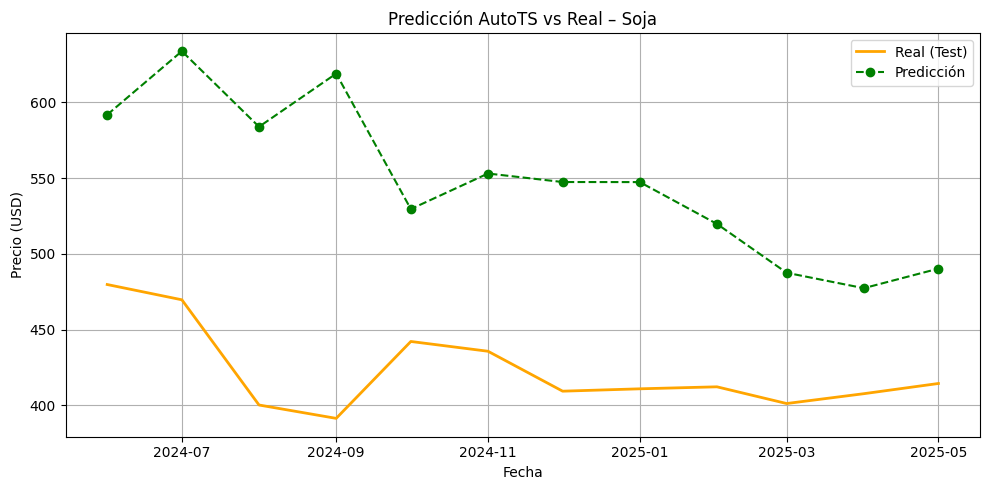

In [ ]:
from src.data import load_all
from autots import AutoTS
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1) Cargar todo el DataFrame (índice = fecha)
data = load_all()

# 2) Seleccionar la serie de SOJA
serie = data['soja']

# 3) Split tren-test (últimos 12 valores)
forecast_length = 12
df_train = serie[:-forecast_length]
df_test  = serie[-forecast_length:]

# 4) Formato largo para AutoTS
df_autots = (
    df_train.reset_index()
             .rename(columns={'fecha': 'datetime', 'soja': 'value'})
)
df_autots['series_id'] = 'soja'
df_autots = df_autots[['datetime', 'value', 'series_id']]


# 5)
model_soja = AutoTS(forecast_length=forecast_length).import_template(
     "templates/best_soja.csv", method="only"
 ).fit(df_autots, date_col='datetime', value_col='value', id_col='series_id')


# 6) Predecir
forecast_df = model_soja.predict().forecast
if 'soja' in forecast_df.index:
    y_pred = forecast_df.loc['soja'].values
elif 'soja' in forecast_df.columns:
    y_pred = forecast_df['soja'].values
else:
    y_pred = forecast_df.values.flatten()

y_true      = df_test.values
fechas_test = df_test.index

# 7) Métricas
mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("📊 Evaluación AutoTS – Soja")
print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")

# 8) Gráfico
plt.figure(figsize=(10, 5))
plt.plot(fechas_test, y_true, label="Real (Test)", color='orange', linewidth=2)
plt.plot(fechas_test, y_pred, label="Predicción",  color='green', linestyle='--', marker='o')
plt.title("Predicción AutoTS vs Real – Soja")
plt.xlabel("Fecha"); plt.ylabel("Precio (USD)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



In [ ]:
print("📌 Mejor modelo AutoTS – Soja")
print(model_soja.best_model)

📌 Mejor modelo AutoTS – Soja
                                  ID Model  \
21  0985c1beaf0813c6da57f93c83d732b0   ETS   

                                      ModelParameters  \
21  {"damped_trend": false, "trend": null, "season...   

                             TransformationParameters  Ensemble  
21  {"fillna": "ffill", "transformations": {"0": "...         0  


#### 4.1.1📋 Cuadro resumen de evaluación con AutoTS

| Cultivo  | Modelo Seleccionado    | MAE   | RMSE  | MAPE     |
|----------|------------------------|-------|-------|----------|
| 🥩 Carne | ETS                    | 0.43  | 0.50  | 6.66%    |
| 🌽 Maíz  | GLS                    | 33.74 | 39.48 | 17.35%   |
| 🌱 Soja  | ETS                    | 70.54 | 75.86 | 17.14%   |


## 5. Comparación Final de Modelos y Selección del Ganador


En base a los cuadros comparativos por categoría y los valores de las métricas (especialmente **RMSE** como criterio principal), se observa que:

| Cultivo| Baseline Naïve| ML Clásico       | Redes Neuronales     | Modelos Estadísticos     | AutoTS         | Ganador Final     |
|--------|---------------|------------------|----------------------|------------------------- |----------------|-------------------|
| Carne  | 0.9           | AdaBoost(0.311)  |LSTM ajustado(0.215)  |GLM Gaussiano(0.193)      |ETS(0.50)       | **GLM Gaussiano** |
| Maíz   | 32.47         | GBoosting (21.15)| NNAR ajustado (17.47)|GLM Gaussiano (16.74)     |GLS (39.48)     | **GLM Gaussiano** |
| Soja   | 137.84        | AdaBoost (48.65) | LSTM simple (37.38)  |GLM Gaussiano (32.56)     |AVNaive (75.86) | **GLM Gaussiano** |


> 🔍 *El modelo `GLM Gaussiano` resultó ser el más eficiente en todos los casos, logrando el menor error cuadrático medio (RMSE), y mostrando mayor estabilidad frente a otros enfoques. 


## 6. Pronóstico con el Modelo seleccionado GLM Gaussiano



 Pronóstico para CARNE


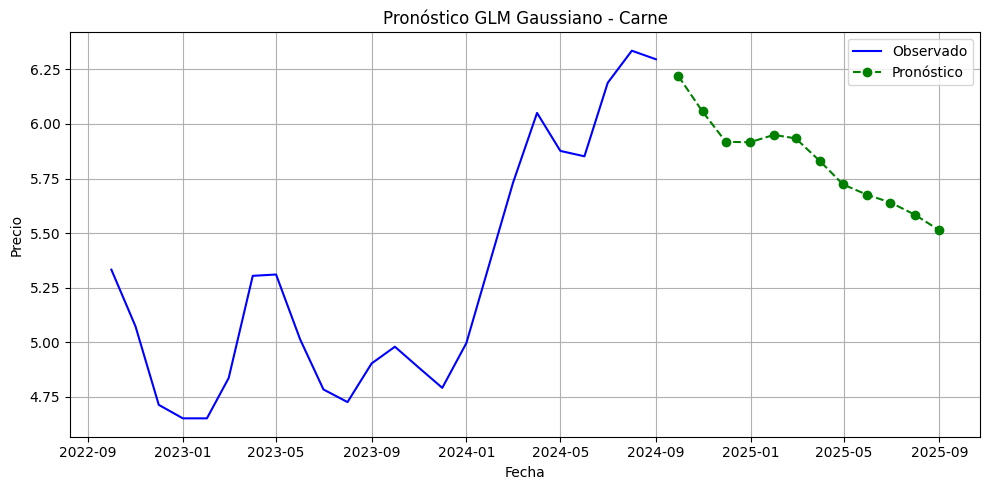

     Fecha  Pronóstico
2024-09-30    6.218339
2024-10-31    6.056862
2024-11-30    5.917864
2024-12-31    5.916123
2025-01-31    5.949723
2025-02-28    5.933636
2025-03-31    5.830297
2025-04-30    5.722600
2025-05-31    5.675433
2025-06-30    5.640054
2025-07-31    5.584953
2025-08-31    5.515008

 Pronóstico para MAIZ


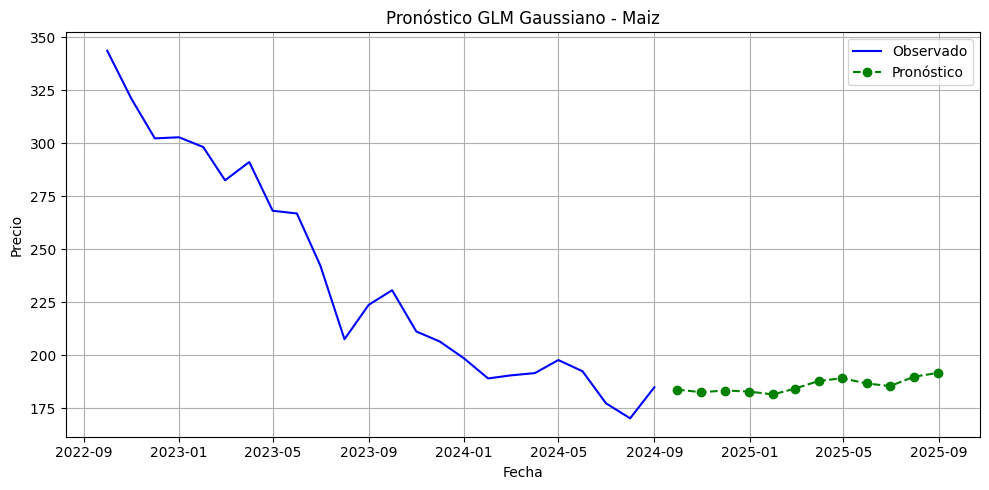

     Fecha  Pronóstico
2024-09-30  183.889812
2024-10-31  182.646779
2024-11-30  183.432557
2024-12-31  182.966258
2025-01-31  181.590887
2025-02-28  184.320199
2025-03-31  187.982362
2025-04-30  189.236793
2025-05-31  186.757814
2025-06-30  185.537037
2025-07-31  189.967805
2025-08-31  191.778158

 Pronóstico para SOJA


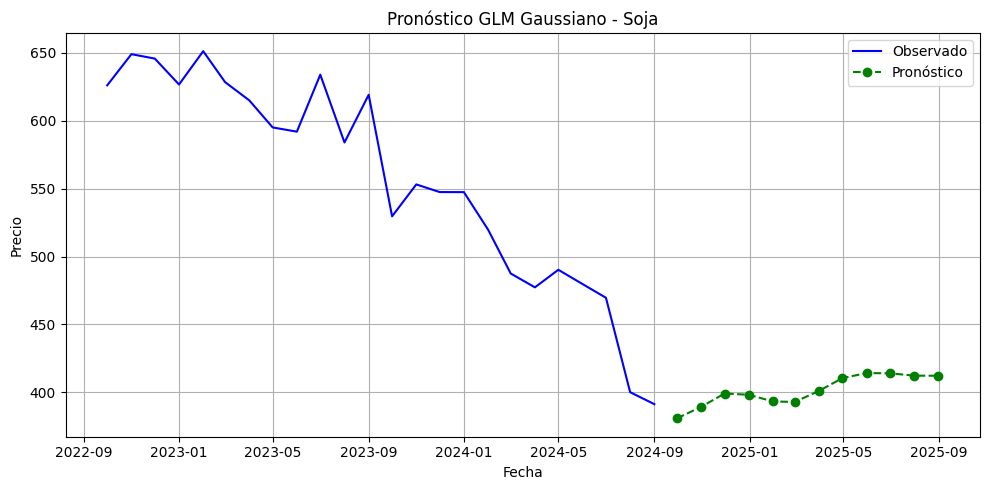

     Fecha  Pronóstico
2024-09-30  380.858524
2024-10-31  389.345667
2024-11-30  399.159403
2024-12-31  398.214018
2025-01-31  393.295262
2025-02-28  392.958759
2025-03-31  401.109207
2025-04-30  410.506871
2025-05-31  414.182482
2025-06-30  414.030264
2025-07-31  412.281310
2025-08-31  412.237166


In [ ]:
from src.data import load_all
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Cargar datos
data = load_all()

# Parámetros
n_lags = 12
horizonte_prediccion = 12
cultivos = ['carne', 'maiz', 'soja']

# Función para crear ventanas
def create_lags_for_forecast(series, n_lags):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Función para pronóstico con GLM Gaussiano
def forecast_glm(series, nombre):
    # Crear características
    X, y = create_lags_for_forecast(series.values, n_lags)
    poly = PolynomialFeatures(degree=1, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Entrenar modelo con todos los datos disponibles
    model = LinearRegression()
    model.fit(X_poly, y)

    # Última ventana para pronóstico
    last_window = series.values[-n_lags:]
    forecast = []

    for _ in range(horizonte_prediccion):
        input_poly = poly.transform(last_window.reshape(1, -1))
        next_pred = model.predict(input_poly)[0]
        forecast.append(next_pred)
        last_window = np.roll(last_window, -1)
        last_window[-1] = next_pred

    # Fechas futuras
    future_dates = pd.date_range(start=series.index[-1] + pd.offsets.MonthEnd(1), periods=horizonte_prediccion, freq='M')

    # Gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(series.index[-24:], series.values[-24:], label="Observado", color='blue')
    plt.plot(future_dates, forecast, label="Pronóstico", color='green', linestyle='--', marker='o')
    plt.title(f"Pronóstico GLM Gaussiano - {nombre}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({'Fecha': future_dates, 'Pronóstico': forecast})

# Ejecutar para cada cultivo
for cultivo in cultivos:
    print(f"\n Pronóstico para {cultivo.upper()}")
    resultado = forecast_glm(data[cultivo], cultivo.capitalize())
    print(resultado.to_string(index=False))


## 7. Análisis de Estacionalidad (STL)

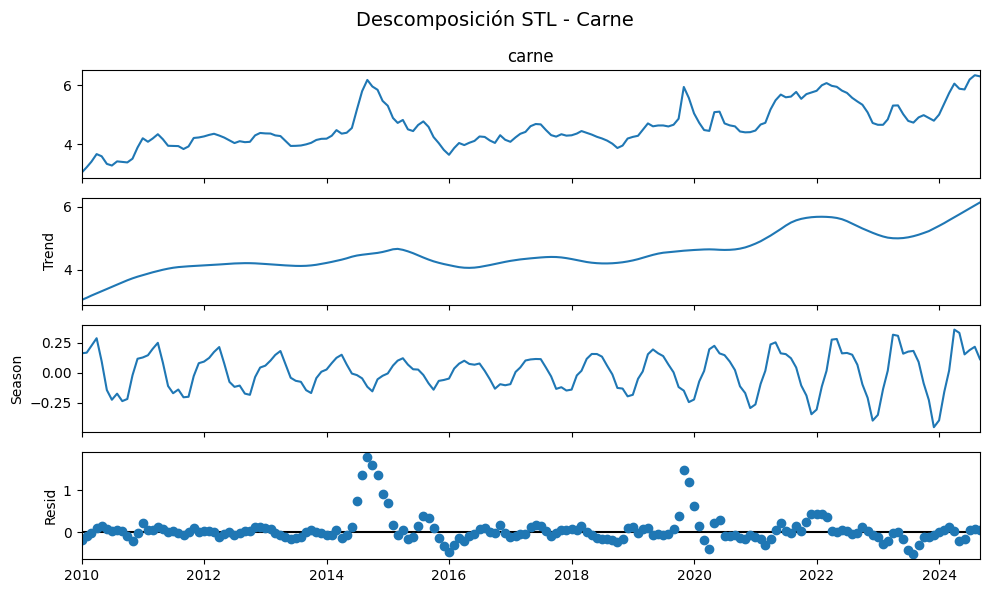

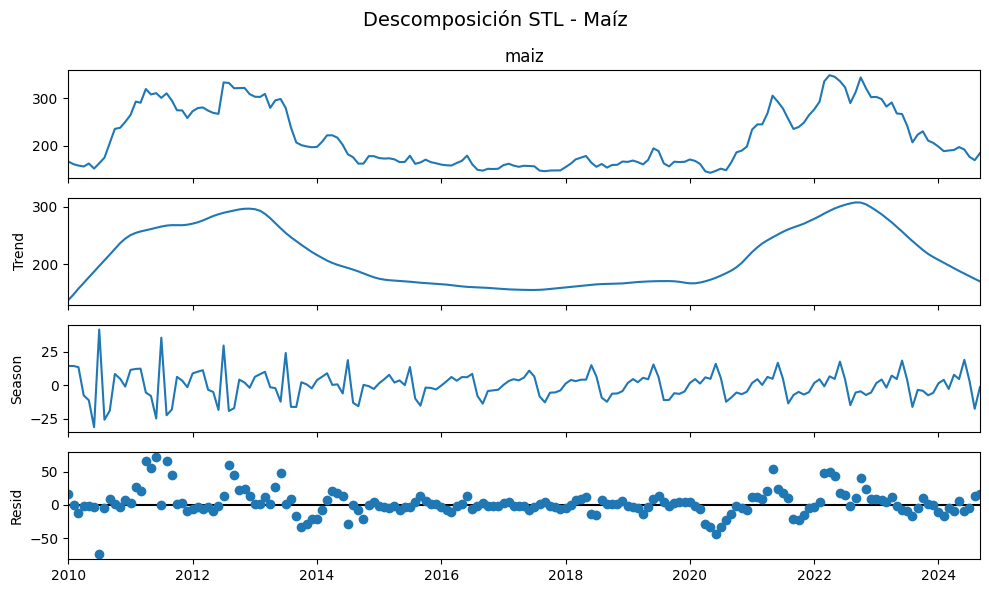

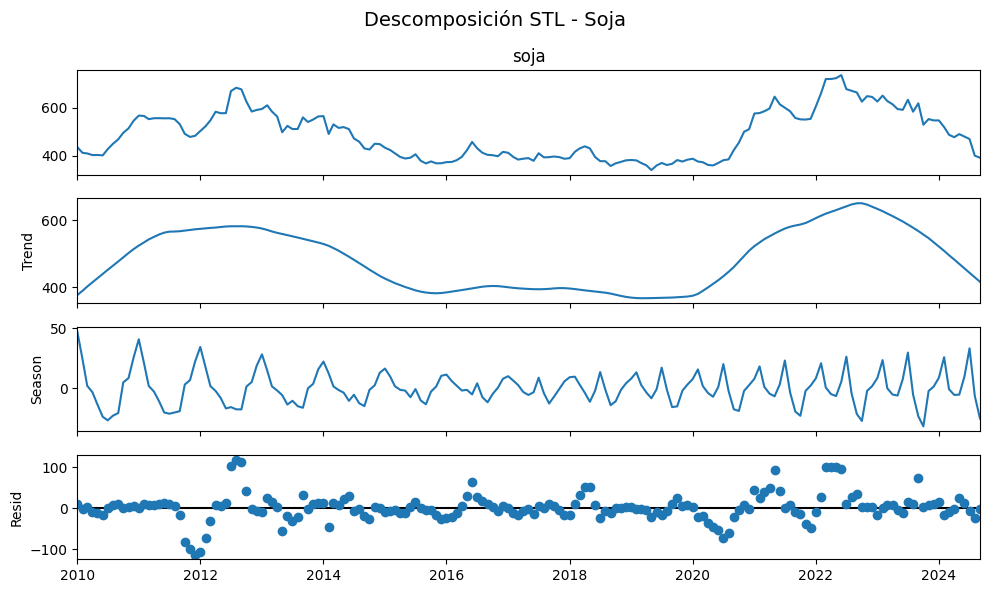

In [ ]:

from src.data import load_allimport pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Cargar los datos
data = load_all()

# Definir función para descomposición STL
def plot_stl(serie, nombre):
    stl = STL(serie, seasonal=13, robust=True)
    result = stl.fit()

    # Graficar
    fig = result.plot()
    fig.set_size_inches(10, 6)
    fig.suptitle(f'Descomposición STL - {nombre}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Aplicar para cada cultivo
plot_stl(data['carne'], 'Carne')
plot_stl(data['maiz'], 'Maíz')
plot_stl(data['soja'], 'Soja')


 Análisis de Estacionalidad y Tendencia (STL)

Se aplicó la descomposición STL (Seasonal-Trend decomposition using Loess) a cada una de las series para observar sus componentes y validar si la elección del modelo GLM Gaussiano y el ensemble de Autogluon fueron adecuados.

- **Carne:** La serie presenta una tendencia suave y una estacionalidad leve pero consistente. Esto sugiere que un modelo con supuestos lineales y distribución gaussiana, como el GLM Gaussiano, puede capturar adecuadamente el comportamiento general.
- **Maíz:** Exhibe una variabilidad más alta y patrones menos definidos de estacionalidad, lo que justifica el desafío en su modelado. Aun así, se aprecia una tendencia creciente reciente que el GLM supo capturar de forma parcial.
- **Soja:** Muestra la estacionalidad más clara entre los tres cultivos, con una tendencia creciente y oscilaciones regulares. Esto también respalda la buena performance del modelo GLM Gaussiano en esta serie.

La descomposición STL sirvió para entender mejor el comportamiento subyacente de cada serie, y por qué un modelo como el GLM Gaussiano —que asume cierta linealidad y distribución normal de errores— resultó efectivo.


## 8. Evaluación Ex-post con Datos Reales Observados (Oct 2024 – May 2025)

📊 Comparación para Carne
MAE: 0.58
RMSE: 0.68
MAPE: 8.83%



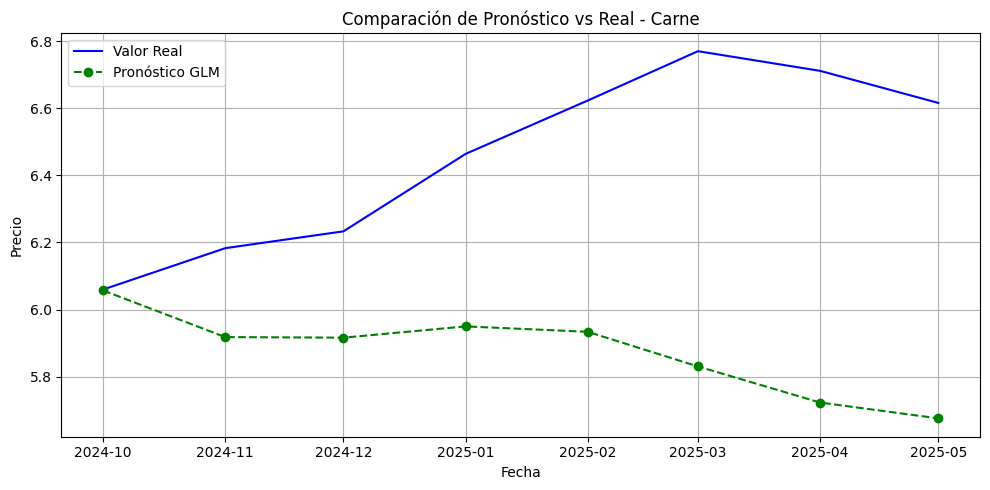

📊 Comparación para Maíz
MAE: 22.12
RMSE: 23.75
MAPE: 10.53%



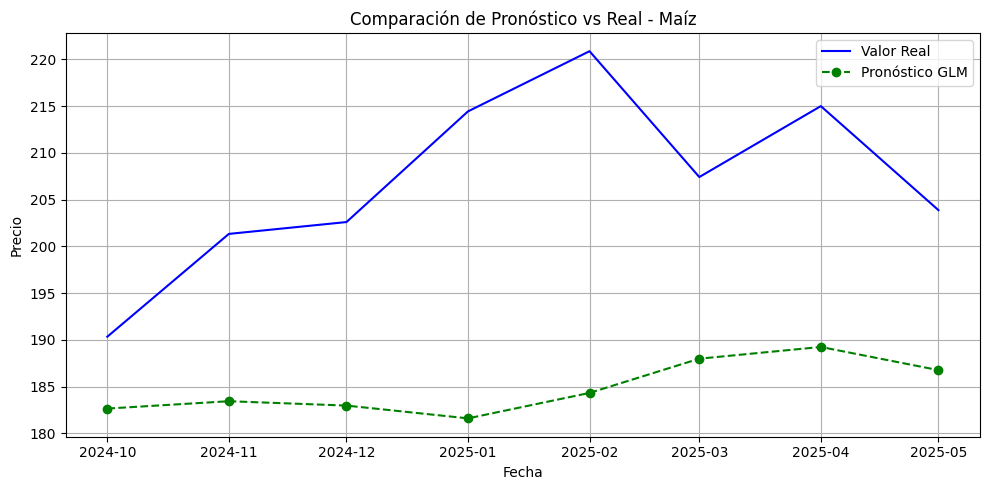

📊 Comparación para Soja
MAE: 17.51
RMSE: 24.80
MAPE: 4.09%



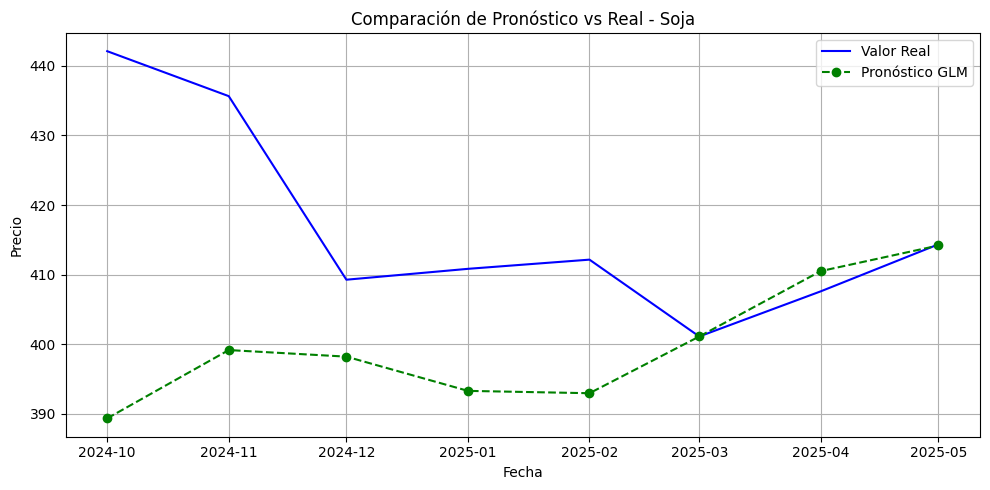

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Cargar el archivo actualizado con los datos reales
df = pd.read_excel("precios commodities.xlsx")
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)

# Ajustar las fechas del pronóstico (PRIMER día de cada mes)
fechas_forecast = pd.date_range(start='2024-10-01', periods=8, freq='MS')  # MS = Month Start

# Pronósticos GLM previos (ejemplo: carne)
pred_carne = [6.056862, 5.917864, 5.916123, 5.949723, 5.933636, 5.830297, 5.722600, 5.675433]
pred_maiz  = [182.646779, 183.432557, 182.966258, 181.598887, 184.320199, 187.982362, 189.236793, 186.757814]
pred_soja  = [389.345667, 399.159403, 398.214018, 393.295262, 392.958759, 401.109207, 410.506871, 414.182482]

# Función para comparar y graficar
def comparar_pronostico(df_real, forecast_values, col_name, titulo):
    fechas_disponibles = fechas_forecast[:len(forecast_values)]
    real_values = df_real[col_name].loc[fechas_disponibles]

    # Calcular métricas
    mae = mean_absolute_error(real_values, forecast_values)
    rmse = mean_squared_error(real_values, forecast_values, squared=False)
    mape = np.mean(np.abs((real_values - forecast_values) / real_values)) * 100

    # Mostrar métricas
    print(f"📊 Comparación para {titulo}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%\n")

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(fechas_disponibles, real_values, label='Valor Real', color='blue')
    plt.plot(fechas_disponibles, forecast_values, label='Pronóstico GLM', color='green', linestyle='--', marker='o')
    plt.title(f'Comparación de Pronóstico vs Real - {titulo}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ejecutar para cada serie
comparar_pronostico(df, pred_carne, 'carne', 'Carne')
comparar_pronostico(df, pred_maiz, 'maiz', 'Maíz')
comparar_pronostico(df, pred_soja, 'soja', 'Soja')


📌 Validación del Pronóstico con Datos Reales (Oct 2024 – May 2025)

Para evaluar la capacidad predictiva del modelo seleccionado (GLM Gaussiano), se compararon los pronósticos generados para los próximos 12 meses con los valores reales efectivamente observados entre octubre 2024 y mayo 2025. Esto permitió medir el rendimiento del modelo más allá del set de entrenamiento.

### 📊 Resultados por cultivo:

| Cultivo   | MAE (Real vs Pred.) | RMSE     | MAPE    |
|-----------|---------------------|----------|---------|
| 🍖 Carne  | **0.58**            | 0.68     | 8.83%   |
| 🌽 Maíz   | **22.12**           | 23.75    | 10.53%  |
| 🌱 Soja   | **17.51**           | 24.80    | **4.09%** |

> 📌 *Nota: MAPE inferior al 10% suele considerarse aceptable en modelos univariantes simples. En el caso de la soja, el rendimiento fue sobresaliente.*

---

### 📈 Análisis visual

Se graficaron las predicciones frente a los valores observados para evaluar su comportamiento:

- **Soja:** el modelo logró anticipar correctamente la dirección y magnitud general de los precios. Excelente ajuste visual y numérico.
- **Carne:** el modelo subestimó la tendencia alcista, aunque se mantuvo dentro de márgenes aceptables.
- **Maíz:** el modelo capturó parcialmente el nivel pero no pudo prever la aceleración de precios a partir de enero, lo que sugiere la influencia de factores exógenos no incluidos en el modelo.

---

### 🧠 Resultado

El GLM Gaussiano, pese a su simplicidad, logró resultados satisfactorios para dos de las tres series evaluadas. En el caso del maíz, el error mayor resalta la necesidad de explorar modelos más complejos (como redes neuronales o enfoques multivariantes con variables exógenas) para capturar comportamientos menos lineales.



## 9. Reflexión Final y Apredizajes

Reflexiones y Aprendizajes Finales

Este proyecto representó una valiosa oportunidad para aplicar distintos enfoques de modelado de series temporales sobre un conjunto de datos reales de commodities. A lo largo del trabajo:

- Se exploraron más de 20 modelos, incluyendo técnicas estadísticas, machine learning, deep learning y autoML.
- El modelo GLM Gaussiano fue seleccionado como el mejor en base al criterio MAPE.
- Se validó que en dos de las tres series el pronóstico tuvo un desempeño razonable. 
- Se comprendió la importancia de evaluar tanto visual como numéricamente, y se reforzó la utilidad de herramientas como la descomposición STL para interpretar el comportamiento de las series.
- Finalmente, se evidenció que un modelo "mejor" no siempre garantiza una predicción perfecta, y que el modelado es un proceso iterativo, donde la interpretación de los resultados es tan importante como la precisión de las métricas.

Este trabajo queda como parte fundamental de mi portfolio como cientista de datos aplicada al agro, combinando herramientas modernas, pensamiento crítico y comunicación clara de resultados.

